

# Instalações de Bibliotecas

In [1]:
!pip install yfinance

  Created wheel for multitasking: filename=multitasking-0.0.10-py3-none-any.whl size=8500 sha256=99637c9a59fb309e0208f7102ef79b65dfb7a5bdf20634638debdd5ab4ef5f8a
  Stored in directory: c:\users\yasin mghazli\appdata\local\pip\cache\wheels\f2\b5\2c\59ba95dcf854e542944c75fe3da584e4e3833b319735a0546c
Successfully built multitasking


In [2]:
pip install neurokit2

Note: you may need to restart the kernel to use updated packages.


In [3]:
!pip install pmdarima

In [4]:
!pip install hurst


# Importação de codigos


##Load the TensorBoard

In [26]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
import tensorflow as tf
import datetime, os
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


##Import data

In [27]:
#IBOVESPA (^BVSP)
#NASDAQ Composite (^IXIC)
#Dow Jones Industrial Average (^DJI)
#CAC 40 (^FCHI)
#FTSE 100 (^FTSE) 
#DAX PERFORMANCE-INDEX (^GDAXI)
Indices = ["BVSP",
           "IXIC",
           "DJI",
           "FCHI",
           "FTSE",
           "GDAXI"
           ]

In [28]:
def import_indices(index= Indices,
            start="2000-01-01",
            end="2017-12-31",
            a=0.1,
            b=0.9):
    indices_importados = []    
    indices_importados_normalizados = []
    for e in Indices:
        timeseries= importdata(TS=(str("^")+e), start=start,end=end)
        indices_importados.append(timeseries)

        minmaxscaler = MinMax(timeseries,a,b)
        locals()[e]  = minmaxscaler[0]
        indices_importados_normalizados.append(locals()[e])
    return indices_importados,indices_importados_normalizados
    

In [29]:
import yfinance as yf
import neurokit2 as nk

def importdata(TS,
               start, 
               end,
               interval = "1d",               
               period = None,
               ):
  
    data = yf.download(  # or pdr.get_data_yahoo(...
            # tickers list or string as well
            tickers = TS,

            # use "period" instead of start/end
            # valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
            # (optional, default is '1mo')
            period = period,  
            start = start,
            end=end,          

            # fetch data by interval (including intraday if period < 60 days)
            # valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
            # (optional, default is '1d')
            interval = interval,

            # group by ticker (to access via data['SPY'])
            # (optional, default is 'column')
            group_by = 'ticker',

            # adjust all OHLC automatically
            # (optional, default is False)
            auto_adjust = True,

            # download pre/post regular market hours data
            # (optional, default is False)
            prepost = False,

            # use threads for mass downloading? (True/False/Integer)
            # (optional, default is True)
            threads = True,

            # proxy URL scheme use use when downloading?
            # (optional, default is None)
            proxy = None
        )
    return data['Close'] 

In [30]:
df = importdata(TS = ('ETH-USD'),
               start="2000-01-01", 
               end ="2019-12-30",
               interval = "2mod")

[*********************100%***********************]  1 of 1 completed

1 Failed download:
- ETH-USD: Invalid input - interval=2mod is not supported. Valid intervals: , 2m, 5m, 15m, 30m, 60m, 90m, 1h, 1d, 5d, 1wk, 1mo, 3mo]


##MinMax

In [31]:
import matplotlib.pyplot as plt
def MinMax(df,a=0,b=1):
  normalizados = []
  for e in df:
    xn = a+(e - df.min())*(b-a) / (df.max() - df.min())
    normalizados.append(xn)
  df_normalizado = pd.DataFrame(normalizados)
  df_normalizado_series = pd.Series(normalizados, index=df.index)
  return df_normalizado_series, df.min(), df.max()

In [32]:
import matplotlib.pyplot as plt
def MinMax_valid_test(df,min, max):
  normalizados = []
  for e in df:
    xn = 0.1 + (e - min)*(0.8) / (max - min)
    normalizados.append(xn)
  df_normalizado = pd.DataFrame(normalizados)
  df_normalizado_series = pd.Series(normalizados, index=df.index)
  return df_normalizado_series

## ACF and PACF

In [33]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd

def acf_pacf(df):
    acf_values=sm.tsa.stattools.acf(df, nlags=(len(df)-1),fft=True)
    pacf=sm.tsa.stattools.pacf(df,method='ols')
    fac_min, fac_max, pacf = np.where(acf_values<=1/np.e)[0][0], np.where(acf_values<=0)[0][0], np.where(pacf<=(1-pacf[np.where(pacf<0)[0][0]-1]))[0][0]
    return pacf, fac_min, fac_max 

In [34]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def acf(df):
    fig = plt.figure(figsize=(25,10))
    ax1 = fig.add_subplot(222)
    fig = sm.graphics.tsa.plot_acf(df, lags=(len(df)-1), ax=ax1,)

def pacf(df):
    fig = plt.figure(figsize=(25,10))
    ax1 = fig.add_subplot(222)
    fig = sm.graphics.tsa.plot_pacf(df, ax=ax1)   

In [35]:
def visualize_loss(history, title):
    loss_train = history.history['loss']
    loss_val = history.history['val_loss']
    plt.plot(loss_train, 'g', label='Training loss')
    plt.plot(loss_val, 'b', label='validation loss')
    plt.title('Training and Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

##Splits Timelags

In [36]:
import numpy as np
import statsmodels.api as sm
# split a univariate sequence into samples
def split_sequence(df, Time_Lag, delay=0):
    X, y = list(), list()
    for i in range(len(df)):
        # find the end of this pattern
        end_ix = i + Time_Lag
        # check if we are beyond the sequence
        if end_ix > len(df)-1:
          break
        # gather input and output parts of the pattern
        if delay != 0:
            seq_x, seq_y = df[i+delay:end_ix+delay], df[end_ix]
        else:
            seq_x, seq_y = df[i:end_ix], df[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [37]:
import numpy as np
import statsmodels.api as sm
# split a univariate sequence into samples
def split_sequence_takens(df,tau, dy, diff=False, delay=0):
    X, y = list(), list()
    df.reset_index(drop=True, inplace=True)
    dy = dy*tau

    if  diff == True:
        df= differentiation(df)

    for i in range(len(df)):
        # find the end of this pattern
        end_ix = i + dy
        # check if we are beyond the sequence
        if end_ix > len(df)-1:
          break
        # gather input and output parts of the pattern
        if delay != 0:
            seq_x, seq_y = df[i+delay:end_ix+delay:tau], df[end_ix]
        else:
            seq_x, seq_y = df[i:end_ix:tau], df[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [38]:
a=split_sequence_takens(df,tau=2, dy=6)   
print(a[0][:10])
print(np.array(a[1][:10]))

[]
[]


##Diff

In [39]:
import pandas as pd
def differentiation(df, show=False):
    df_diff = df - df.shift()
    if show ==True:
       df_diff.plot(lw=.8,  
                    kind='line', 
                    xlabel = "",
                    ylabel = "Valor de Fechamento Normalizado",
                    label='Valor de Fechamento Diario',    
                    title='')
    return df_diff[1:]

Series([], Name: Close, dtype: float64)

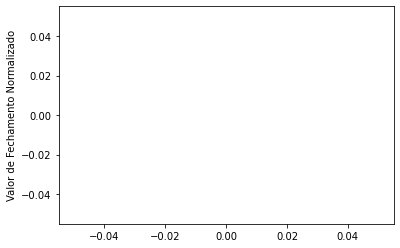

In [40]:
differentiation(df, show=True)

In [41]:
df.shift()

Series([], Name: Close, dtype: float64)

In [42]:
df

Series([], Name: Close, dtype: float64)

In [43]:
df_diff = df - df.shift()
df_diff

Series([], Name: Close, dtype: float64)

##Test ADF

In [44]:
from statsmodels.tsa.stattools import adfuller
def adf(df):
  # ADF Test
  result = adfuller(df, autolag='AIC')
  print(f'ADF Statistic: {result[0]}')
  print(f'n_lags: {result[1]}')
  print(f'p-value: {result[1]}') 
  for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')   
  print("\n")
  if result[1] > 0.05: #p-value
    print("A hipótese nula NÃO é rejeitada porque o p-valor é maior que 0,05." )  
    print("Náo e Estacionária")

  if result[1] < 0.05: #p-value
    print("A hipótese nula é rejeitada porque o p-valor é menor que 0,05.")
    print("Estacionária")
  return result


##Train Validation Test


In [45]:
import neurokit2 as nk
def Train_Validation_Test(df,                         
                            percentual_train=0.9,
                            percentual_validacao=0.05,
                            percentual_test=0.05
                            ):
                            
    k_fold_size = len(df)
    train_data = df[0:int(percentual_train * k_fold_size)]
    pacf, fac_min, fac_max  = acf_pacf(train_data)
    
    tau = 1
    #tau = nk.complexity_delay(train_data, show=False)[0]    
    print("Tau = " + str(tau))

    dy =1
    #dy = acf_pacf(train_data)[1]
    #dy = nk.complexity_dimension(train_data, delay=tau, dimension_max=20, method='afnn', show=False)[0]    
    #dy2 = nk.complexity_dimension(train_data, delay=tau, dimension_max=20, method='fnn', show=False)[0]  
    print("Dy = " + str(dy))
    #print("Dy2 = " + str(dy2))

    validation_data = df[(int(percentual_train * k_fold_size)-(tau*dy)+1):int((percentual_train+percentual_validacao) * k_fold_size)]
    test_data = df[(int((percentual_train+percentual_validacao)*k_fold_size-(tau*dy)+1)):]
    index = df[(int((percentual_train+percentual_validacao)*k_fold_size+1)):]

    return train_data, validation_data, test_data, index, pacf, fac_min, fac_max , tau , dy

In [46]:
df = import_indices()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [47]:
df = df[1][0]

In [48]:
train, validation, test, index, pacf, fac_min, fac_max, tau , dy =Train_Validation_Test((df))

Tau = 1
Dy = 1


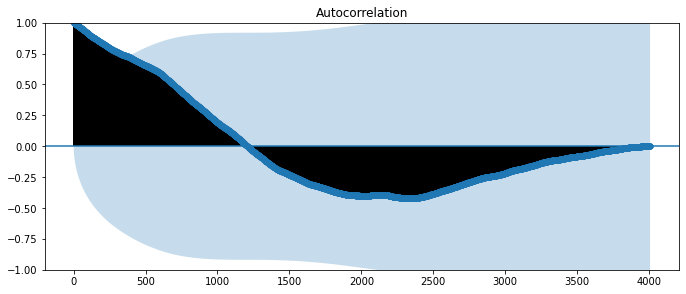

In [49]:
acf(train)

In [50]:
acf_pacf(MinMax(train)[0])

(2, 820, 1208)

In [51]:
def Train_Validation_Test2(df,                         
                            percentual_train=0.6,
                            percentual_validacao=0.2,
                            percentual_test=0.2,
                            plot = False
                            ):
    k_fold_size = len(df)

    train_data = df[0:int(percentual_train * k_fold_size)]
    validation_data = df[(int(percentual_train * k_fold_size)+1):int((percentual_train+percentual_validacao) * k_fold_size)]
    test_data = df[(int((percentual_train+percentual_validacao)*k_fold_size+1)):]
    index = df[(int((percentual_train+percentual_validacao)*k_fold_size+1)):]

    if plot == True: 
       plt.plot(train_data, 'g', label='Train')
       plt.plot(validation_data, 'b', label='Validação')
       plt.plot(test_data, 'c', label='Test')
       plt.title('Train, Validation and Test')
       plt.show()

    return train_data, validation_data, test_data,index

##IMM

(14,
 {'Algorithm': 'first local minimum',
  'Method': 'fraser1986',
  'Metric': 'Mutual Information',
  'Scores': array([4.96965973, 4.68141767, 4.51881307, 4.43154556, 4.3493443 ,
         4.31819162, 4.25086996, 4.21117426, 4.19891863, 4.16769718,
         4.12990321, 4.13150935, 4.1019244 , 4.09445551, 4.09911008,
         4.05020739, 4.06829821, 4.04083121, 4.02115116, 4.02506958,
         4.01067035, 3.98254632, 3.98393142, 3.97446485, 3.9839264 ,
         3.95986509, 3.96816378, 3.95384184, 3.94530345, 3.91159527,
         3.93558207, 3.92325361, 3.89716001, 3.88733473, 3.8878721 ,
         3.89152051, 3.88766419, 3.86347347, 3.86901597, 3.86223745,
         3.87350658, 3.8633186 , 3.87088325, 3.88448038, 3.85871036,
         3.8744577 , 3.85911167, 3.85800835, 3.84920915, 3.86857544]),
  'Values': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
         35, 36, 37, 38, 39, 40

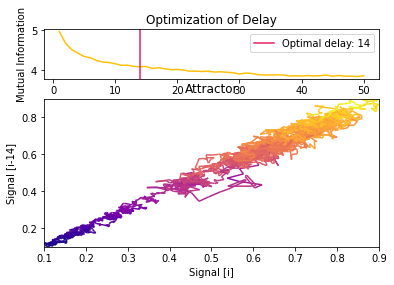

In [52]:
import neurokit2 as nk
train = MinMax(df)
nk.complexity_delay(df, show=True)

##Dimension

In [53]:
nk.complexity_embedding(df, delay=2, dimension=5, show=False)

array([[0.19978577, 0.19179965, 0.1925458 , 0.19562366, 0.20407613],
       [0.18720617, 0.19019076, 0.20085836, 0.19613664, 0.20827322],
       [0.19179965, 0.1925458 , 0.19562366, 0.20407613, 0.21287836],
       ...,
       [0.84682522, 0.85482301, 0.85776097, 0.87897958, 0.88930908],
       [0.84891211, 0.84975153, 0.87835002, 0.88482053, 0.89314476],
       [0.85482301, 0.85776097, 0.87897958, 0.88930908, 0.89314476]])

In [54]:
train, valid, test, index , pacf, fac_min, fac_max , tau, dy = Train_Validation_Test(df)

Tau = 1
Dy = 1


In [55]:
  """References
    ------------
    - Gautama, T., Mandic, D. P., & Van Hulle, M. M. (2003, April). A differential entropy based method for determining the optimal embedding parameters of a signal. In 2003 IEEE International Conference on Acoustics, Speech, and Signal Processing, 2003. Proceedings.(ICASSP'03). (Vol. 6, pp. VI-29). IEEE.
    - Camplani, M., & Cannas, B. (2009). The role of the embedding dimension and time delay in time series forecasting. IFAC Proceedings Volumes, 42(7), 316-320.
    - Rosenstein, M. T., Collins, J. J., & De Luca, C. J. (1994). Reconstruction expansion as a geometry-based framework for choosing proper delay times. Physica-Section D, 73(1), 82-98.  
    
    if method in ["fraser", "fraser1986", "tdmi"]:
        metric = "Mutual Information"
        algorithm = "first local minimum"

    elif method in ["theiler", "theiler1990"]:
        metric = "Autocorrelation"
        algorithm = "first 1/e crossing"

    elif method in ["casdagli", "casdagli1991"]:
        metric = "Autocorrelation"
        algorithm = "first zero crossing"

    elif method in ["rosenstein", "rosenstein1993", "adfd"]:
        metric = "Displacement"
        algorithm = "closest to 40% of the slope"
    else:
    
    """
    

'References\n  ------------\n  - Gautama, T., Mandic, D. P., & Van Hulle, M. M. (2003, April). A differential entropy based method for determining the optimal embedding parameters of a signal. In 2003 IEEE International Conference on Acoustics, Speech, and Signal Processing, 2003. Proceedings.(ICASSP\'03). (Vol. 6, pp. VI-29). IEEE.\n  - Camplani, M., & Cannas, B. (2009). The role of the embedding dimension and time delay in time series forecasting. IFAC Proceedings Volumes, 42(7), 316-320.\n  - Rosenstein, M. T., Collins, J. J., & De Luca, C. J. (1994). Reconstruction expansion as a geometry-based framework for choosing proper delay times. Physica-Section D, 73(1), 82-98.  \n  \n  if method in ["fraser", "fraser1986", "tdmi"]:\n      metric = "Mutual Information"\n      algorithm = "first local minimum"\n\n  elif method in ["theiler", "theiler1990"]:\n      metric = "Autocorrelation"\n      algorithm = "first 1/e crossing"\n\n  elif method in ["casdagli", "casdagli1991"]:\n      metri

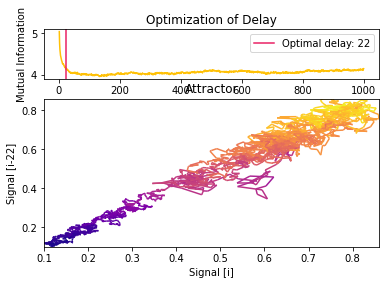

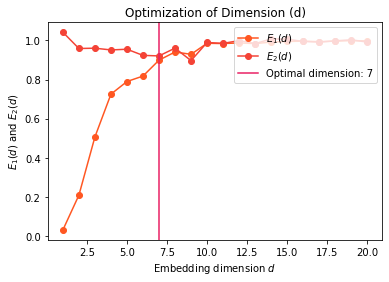

In [56]:
signal = train
# Find optimal delay(TAU)
delay, parameters = nk.complexity_delay(signal, delay_max=1000, method="fraser1986", show=True)

# Find optimal dimension(Dy)
optimal_dimension, info = nk.complexity_dimension(signal, delay=delay, dimension_max=20, method='afnn', show=True)

##Forecasting

In [57]:
def forecasting(model, data, dy, diff=False, tau=1, delay=0): 
    if diff == True:
       data = differentiation(data)      
    X, y = split_sequence_takens(data ,tau, dy, delay) 
    pred_array= model.predict(X, verbose=0)
    index= data[tau*dy:].index
    forecasting , real = pd.DataFrame((pred_array), index) , pd.DataFrame(np.array(y), index)
    forecasting , real = forecasting.rename(columns={0: "close"}) , real.rename(columns={0: "close"})
    evaluate_all(real,forecasting)
    return real, forecasting

##Plot Results


In [58]:
def plot_results(real_data,pred_data, name='Actual and Predicted'):
    plt.plot(np.array(real_data), 'g', label='actual')
    plt.plot(np.array(pred_data), 'b', label='predicted')
    plt.title(name)
    plt.legend()
    plt.show()

##Evaluation

In [59]:
import math
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score

def u1(f,y):
    y = y.reset_index(drop=True).values.flatten()
    f = f.reset_index(drop=True).values.flatten()
    df = pd.DataFrame({'f_i':f, 'y_i': y})
    df['(y_i - f_i)^2'] = np.square(df['y_i'] - df['f_i'])
    df['y_i^2'] = np.square(df['y_i'])
    df['f_i^2'] = np.square(df['f_i'])
    return (np.sqrt(np.mean(df['(y_i - f_i)^2'])))/(np.sqrt(np.mean(df['y_i^2']))+np.sqrt(np.mean(df['f_i^2'])))

def u2(f,y):
    y = y.reset_index(drop=True).values.flatten()
    f = f.reset_index(drop=True).values.flatten()
    df = pd.DataFrame({'f_i+1':f, 'y_i+1': y})
    df['y_i'] = df['y_i+1'].shift(periods=1)
    df['numerator'] = np.square((df['f_i+1'] - df['y_i+1']) / df['y_i'])
    df['denominator'] = np.square((df['y_i+1'] - df['y_i']) / df['y_i'])
    df.dropna(inplace=True)
    return np.sqrt(np.sum(df['numerator'])/np.sum(df['denominator']))


def prediction_of_change_in_direction(y_true, y_pred):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)

    true_sub = np.subtract(y_true[0:(len(y_true) - 1)], y_true[1:(len(y_true))])
    pred_sub = np.subtract(y_pred[0:(len(y_pred) - 1)], y_pred[1:(len(y_pred))])

    mult = true_sub * pred_sub
    result = 0
    for m in mult:
        if m > 0:
            result = result + 1

    return (100 * (result / len(y_true)))

def evaluate_all(actual_df,predicted_df):    

    mse = mean_squared_error(actual, predicted)
    print('MSE: (Mean Squared Error) '+str(mse))

    mae = mean_absolute_error(actual, predicted)
    print('MAE: Mean Absolute Error '+str(mae))

    rmse = math.sqrt(mean_squared_error(actual, predicted))    
    print('RMSE: (Root Mean Square Error): '+str(rmse))

    mape = np.mean(np.abs(predicted - actual)/np.abs(actual))
    print('MAPE (Mean Absolute Percentage Error): '+str(mape))

    pocid = np.mean((np.sign(actual[1:] - actual[:-1]) == np.sign(predicted[1:] - predicted[:-1])).astype(int))
    print('POCID (Prediction of Change in Direction): '+str(pocid))

    r2 = r2_score(actual,predicted) 
    print('R2 (Coeficiente de Determinação): '+str(r2))

    theilsu1 = u1(predicted_df,actual_df)
    print('Theil’s U1 : '+str(theilsu1))

    theilsu2 = u2(predicted_df,actual_df)
    print('Theil’s U2 : '+str(theilsu2))

    return mse,mae,rmse,mape,pocid,r2,theilsu1,theilsu2

##Geral

In [60]:
def resultados(ts=('^BVSP'), 
               model = "narx",
               period = "7d",
               interval = "1m",
               epochs=10000, 
               patience = 10,
               delay=1,
               diff=False
               ):
  
  #Importação da Serie Temporal
  df = importdata(ts,period,interval)
  print("Importação da série temporal concluida")
  
  #Data Train, Data Validation and Data Test
  train, valid, test, index , pacf, fac_min, fac_max , tau , dy = Train_Validation_Test(df)
  print("Data Train, Data Validation and Data Test")

  #Normalização MinMax
  train , min, max = MinMax(train)
  valid = MinMax_valid_test(valid,min,max)
  test = MinMax_valid_test(test,min,max)

  #Diferenciação
  #train = diff(train_)
  #valid = diff(valid_)
  #test = diff(test_)

  print("Normalização concluida")
  if False: 
    plt.plot(train, 'g', label='Train')
    plt.plot(valid, 'b', label='Validação')
    plt.plot(test, 'c', label='Test')
    plt.title('Train, Validation and Test')
    plt.show()

  #Index Data
  print("Divisão dos dados em Treino, validação e teste")

  #Teste de Estacionariedade(ADF)  
  #adf((df - df.shift()))

  #Model
  if model == "narx":
     model=narx(round(dy))
  elif model == 'narx2':
     model= narx2(round(dy))
  elif model == 'mlp':
     model= mlp(round(dy))  
  elif model == 'lstm':
     model= lstm(round(dy))
  
  print("Load Model")
  
  #Time Series Split Rolling Window
  X, y =           split_sequence_takens( train, tau, dy, diff, delay  )   
  X_val, y_val =   split_sequence_takens( valid, tau, dy, diff, delay  ) 
  X_test, y_test = split_sequence_takens( test,  tau, dy, diff, delay=0) 
  print("Rolling Window")

  es = tf.keras.callbacks.EarlyStopping(monitor='loss', verbose=1, patience=patience)
  mc = tf.keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

  print("Train Model")
  #Train Model With (Error stabilization stop criterion)
  X = X.reshape((X.shape[0], X.shape[1]))  
  history=model.fit(X, y, 
                    verbose=1,
                    epochs=epochs, 
                    validation_data=(X_val, y_val),
                    callbacks=[tensorboard_callback,es]
                    )

  #Testing Model
  print("Forecasting Train Data")
  real_train , pred_train = forecasting(model, (train), dy , diff, tau=1, delay=0 )
  print("Forecasting Valid Data")
  real_valid , pred_valid = forecasting(model, (valid), dy , diff, tau=1, delay=0 )
  print("Forecasting Test Data")
  real_test  , pred_test  = forecasting(model, (test),  dy , diff, tau=1, delay=0 )

  #Results
  print("Resultados")
  plot_results(real_train, pred_train,  name='Train Dataset')
  plot_results(real_valid, pred_valid, name='Valid Dataset')
  plot_results(real_test,  pred_test,  name='Test  Dataset')

  return real_test,pred_test,history,model

#Analise de séries temporais.

##Import séries 

In [67]:
#IBOVESPA (^BVSP)
#NASDAQ Composite (^IXIC)
#Dow Jones Industrial Average (^DJI)
#CAC 40 (^FCHI)
#FTSE 100 (^FTSE) 
#DAX PERFORMANCE-INDEX (^GDAXI)
Indices = ["BVSP", "IXIC", "DJI", "FCHI", "FTSE", "GDAXI"]

In [68]:
def import_indices(index= Indices,
            start="2000-01-01",
            end="2019-12-31",
            a=0.1,
            b=0.9):
    indices_importados = []    
    indices_importados_normalizados = []
    for e in Indices:
        timeseries= importdata(TS=(str("^")+e), start=start,end=end)
        indices_importados.append(timeseries)

        minmaxscaler = MinMax(timeseries,a,b)
        locals()[e]  = minmaxscaler[0]
        indices_importados_normalizados.append(locals()[e])
    return indices_importados,indices_importados_normalizados

In [69]:
series_imported= import_indices()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


##Train, Valid Test

In [70]:
def Train_Validation_Test(df,                 
                            train_start="2000-01-01",
                            train_end="2017-12-31",
                            valid_end="2018-12-31",
                            test_end="2019-12-31",):
    train = []
    valid = []
    test = []
    for e in range(len(Indices)):
        data = pd.Series(np.array(df[e]), index= df[e].index)        
        train_minmax = MinMax(data[train_start:train_end],0.1,0.9)
        min = train_minmax[1]  
        max = train_minmax[2] 
        locals()[e]  = train_minmax[0]        
        train_df = pd.DataFrame(np.array(locals()[e]), columns= [(str("^")+Indices[e])], index= data[train_start:train_end].index)
        train.append(train_df)         

        locals()[e]  = MinMax_valid_test(data[train_end:valid_end],min,max)
        valid_df = pd.DataFrame(np.array(locals()[e]), columns= [(str("^")+Indices[e])], index= data[train_end:valid_end].index)
        valid.append(valid_df)
        
        locals()[e]  = MinMax_valid_test(data[valid_end:test_end],min,max)
        test_df = pd.DataFrame(np.array(locals()[e]), columns= [(str("^")+Indices[e])], index= data[valid_end:test_end].index)
        test.append(test_df)

    #[Train_Valid_Test][Indices]
    return train,valid,test 

In [71]:
train,valid,test  = Train_Validation_Test(series_imported[0])

##Estatisticas das séries

In [82]:
train_estatisticas = import_indices( start="2000-01-01",end="2017-12-31")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [73]:
from scipy.stats import kurtosis
from scipy.stats import skew
def estatisticas(series_imported):
    estatisticas = []    
    for e in range(len(series_imported[0])):      
        timeseries = series_imported[0][e]
        timeseriesnormal = series_imported[1][e]
        estatisticas.append((timeseries.min(), 
                     timeseries.max(),
                     len(timeseriesnormal),
                     timeseriesnormal.min(), 
                     timeseriesnormal.max(),
                     timeseriesnormal.mean(),
                     timeseriesnormal.var(),
                     kurtosis(timeseriesnormal),
                     skew(timeseriesnormal),
                     acf_pacf(timeseriesnormal)[0],
                     acf_pacf(timeseriesnormal)[1],
                     acf_pacf(timeseriesnormal)[2]
                     ))        
    estatisticas = pd.DataFrame(np.array((estatisticas)),
                   columns= ["Min", "Max","length","Min", "Max", "Mean", "Var", "Kurtosis", "CA", "PACF", "ACF(1/e)", "ACF(0)"],
                   index= Indices
              )
    return estatisticas         

In [81]:
estatisticas = estatisticas(train_estatisticas)
estatisticas

TypeError: ignored

##Gráficos

##Séries

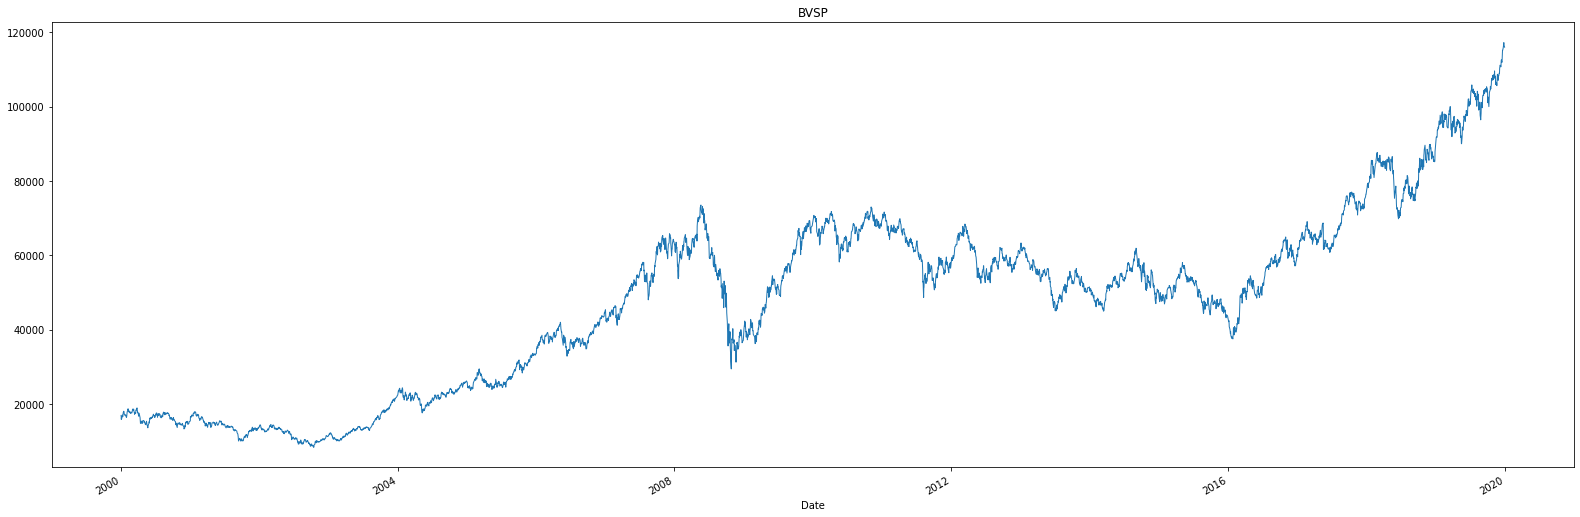

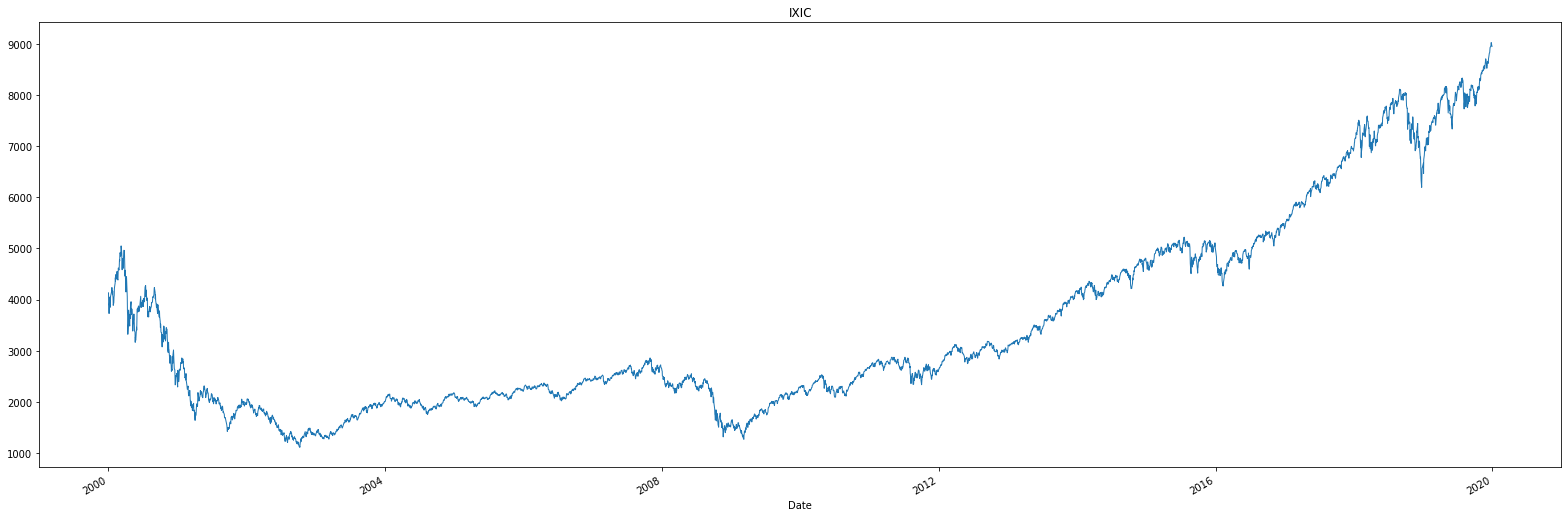

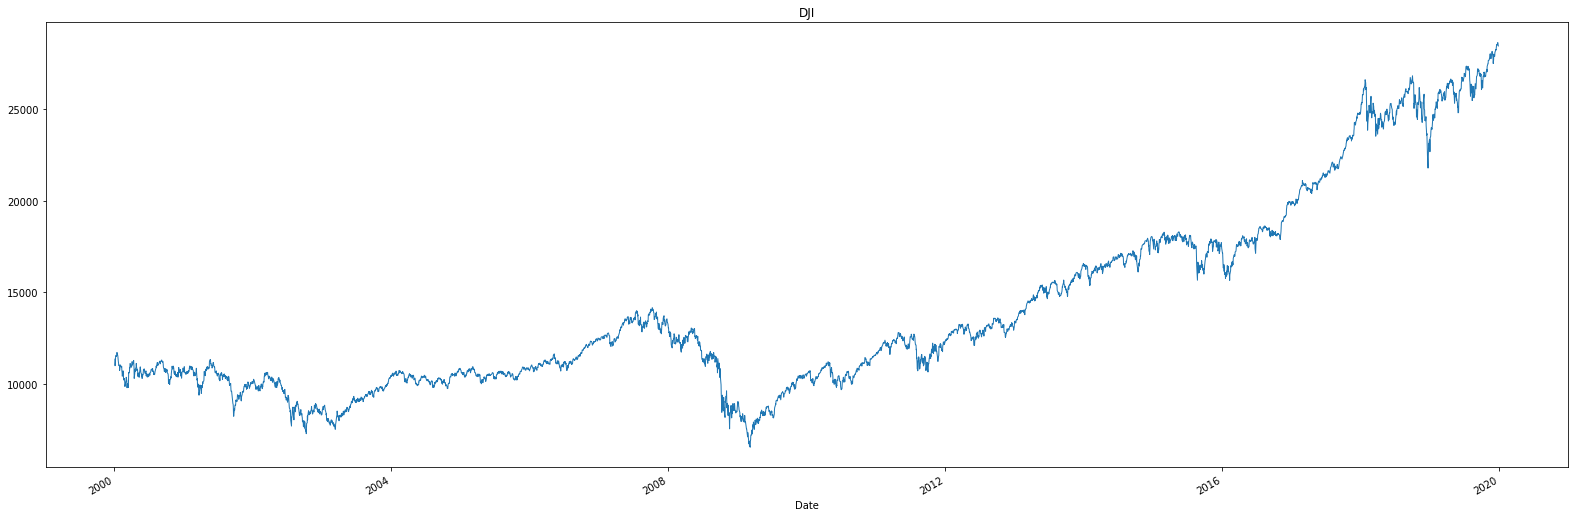

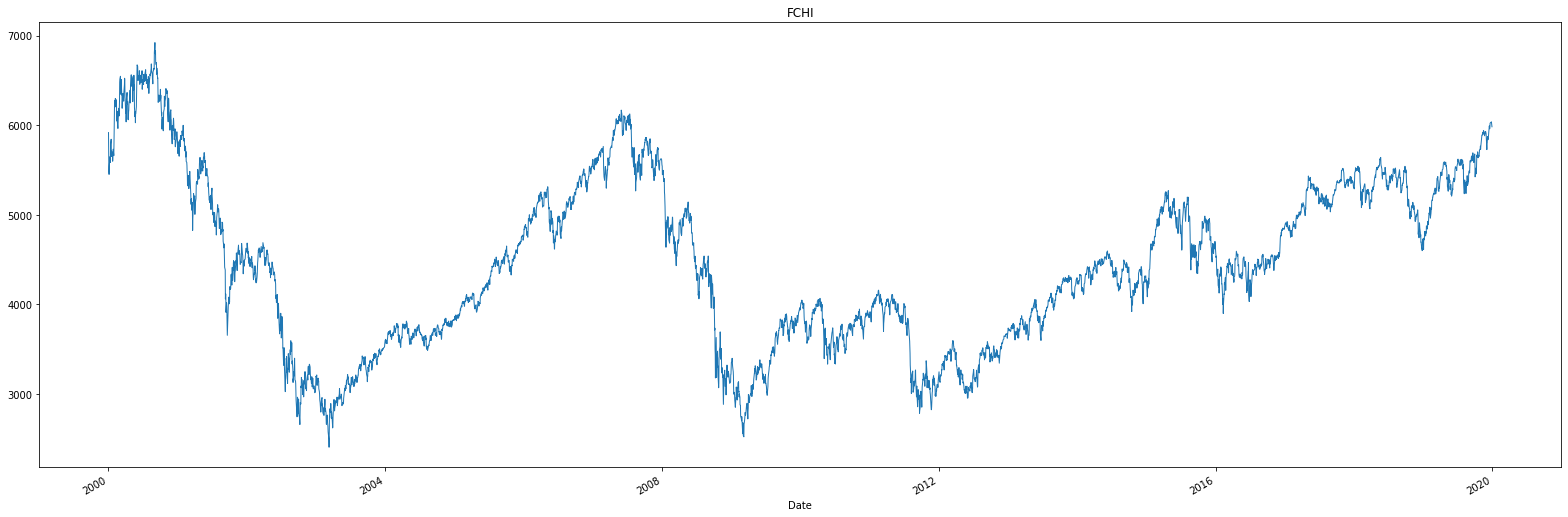

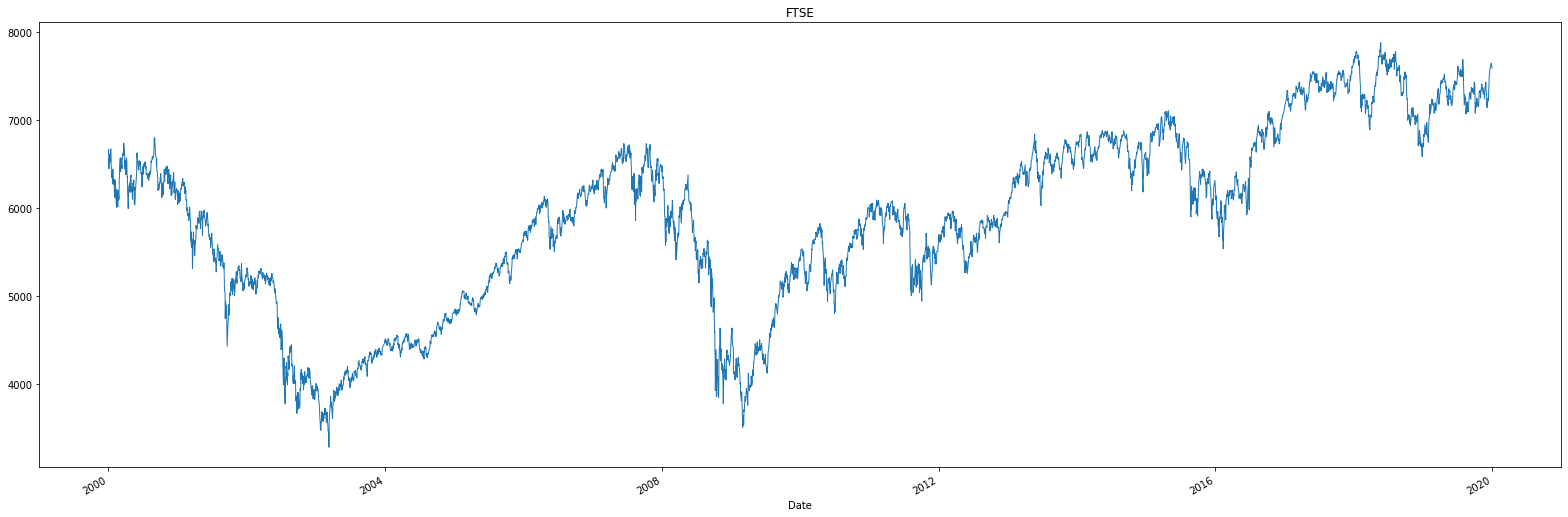

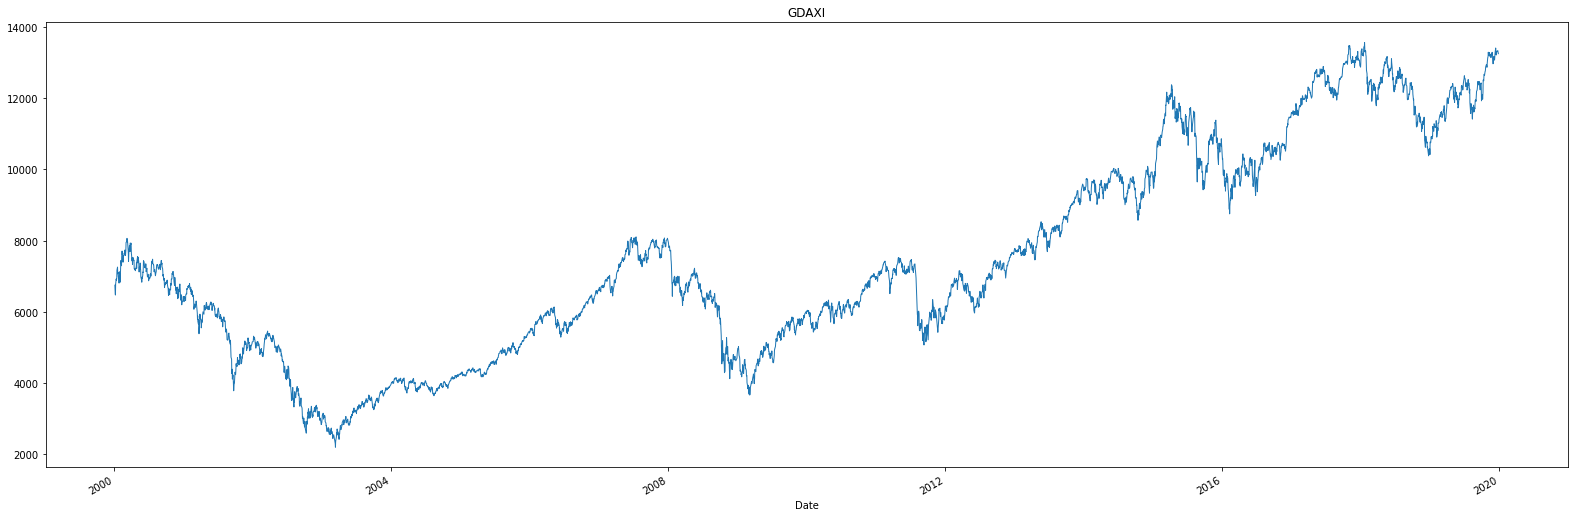

In [80]:
def plot_series(series_imported):    
    for e in range((len(series_imported[0]))):
        fig = plt.figure(figsize=(60,20))
        ax1 = fig.add_subplot(222)        
        title_acf = str(Indices[e]) 
        series_imported[0][e].plot(title=title_acf,ax=ax1,linewidth=1)
plot_series(series_imported)

In [76]:
def plot_series(series_imported):    
    for e in range((len(series_imported[1]))):
        fig = plt.figure(figsize=(25,10))
        ax1 = fig.add_subplot(222)        
        title_acf = str(Indices[e])  + " Normalizada"      
        series_imported[1][e].plot(title=title_acf,ax=ax1) #[1] Série Normalizada

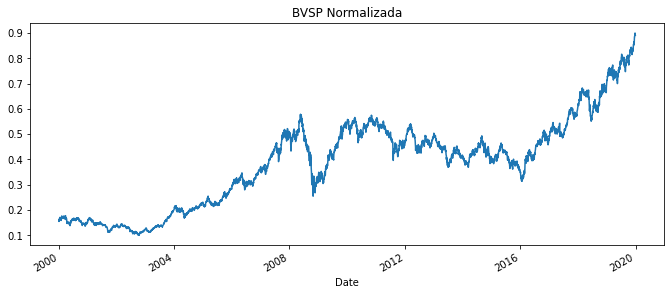

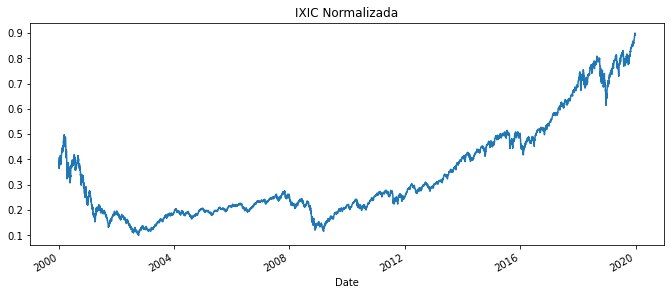

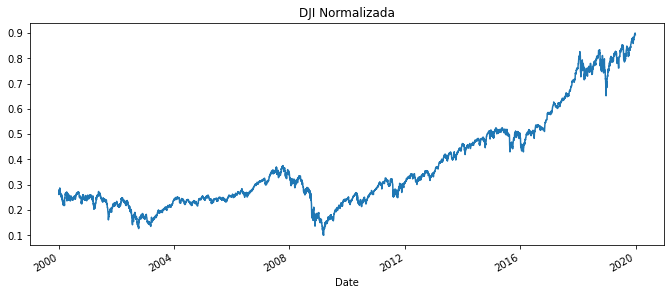

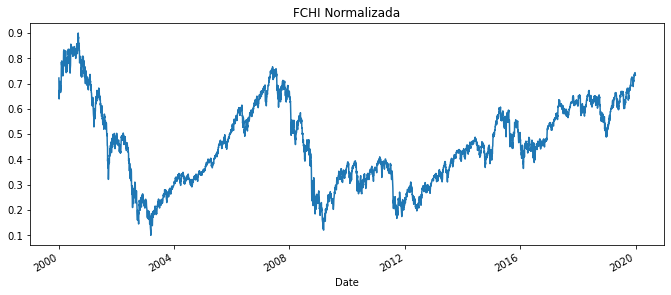

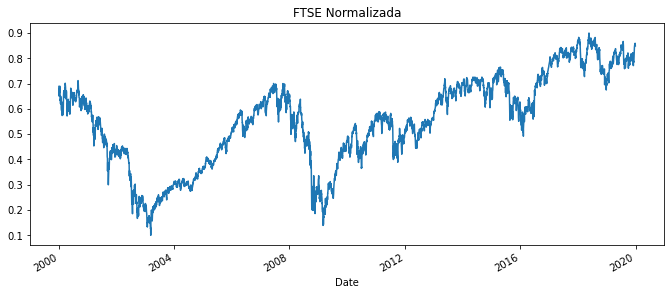

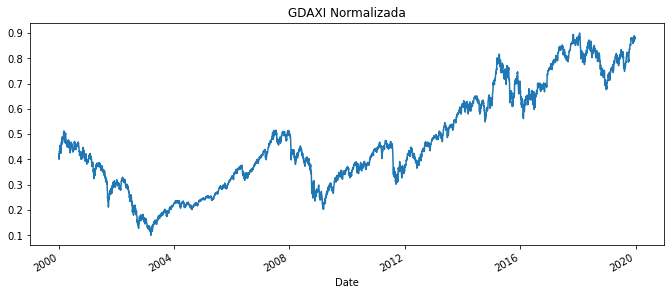

In [77]:
plot_series(series_imported)

###ACF

In [78]:
def plot_acf(series_imported):    
    for e in range((len(series_imported[1]))):
        fig = plt.figure(figsize=(25,10))
        ax1 = fig.add_subplot(222)        
        title_acf = "Autocorrelation " + str(Indices[e])        
        sm.graphics.tsa.plot_acf(series_imported[1][e], title=title_acf,lags=(len(series_imported[1][e])-1), ax=ax1) #[1] Série Normalizada

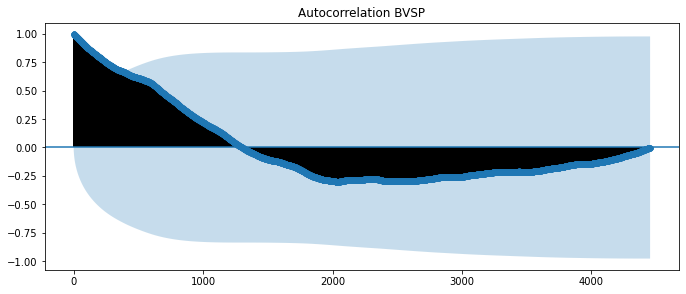

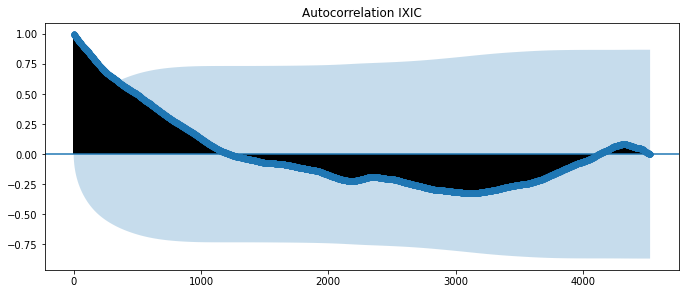

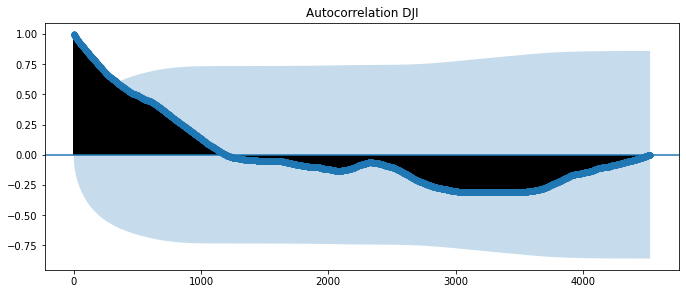

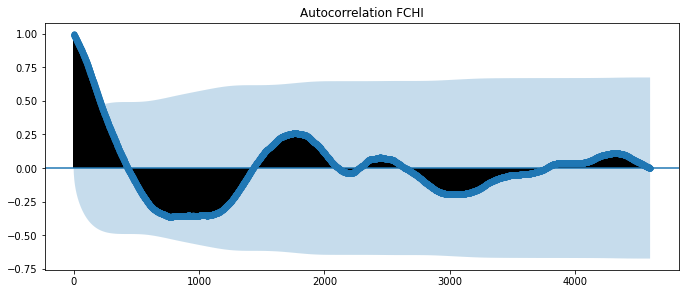

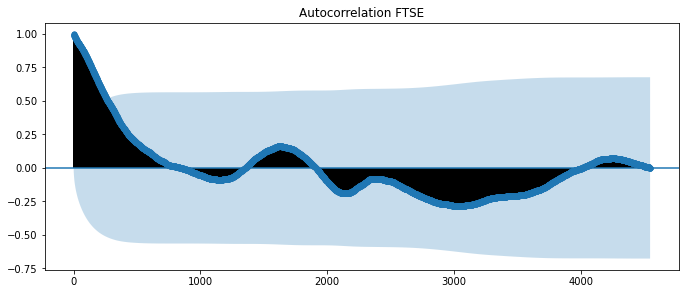

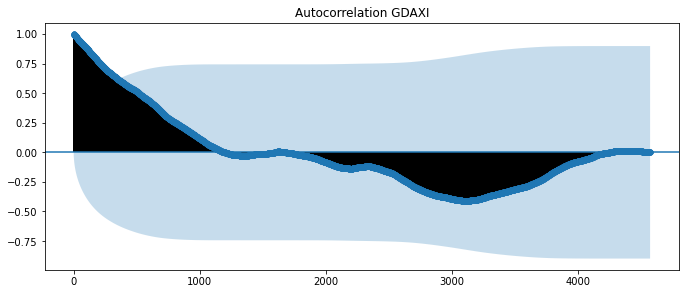

In [ ]:
plot_acf(series_imported)

###PACF

In [ ]:
def plot_pacf(series_imported):
    for e in range(len(series_imported[1])):
        fig = plt.figure(figsize=(25,10))
        ax1 = fig.add_subplot(222)         
        title_pacf = "Partial Autocorrelation " + str(Indices[e])        
        sm.graphics.tsa.plot_pacf(series_imported[1][e], title=title_pacf, lags=100, ax=ax1) #[1] Série Normalizada

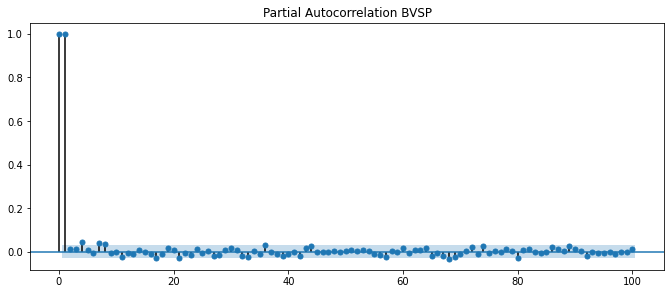

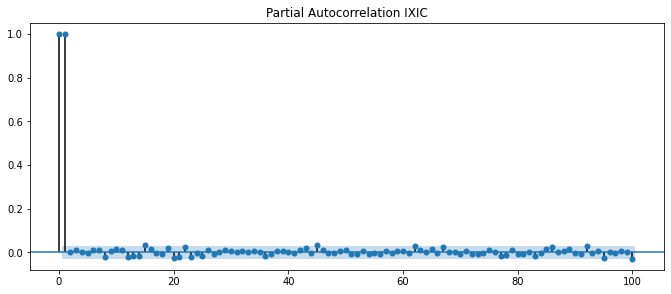

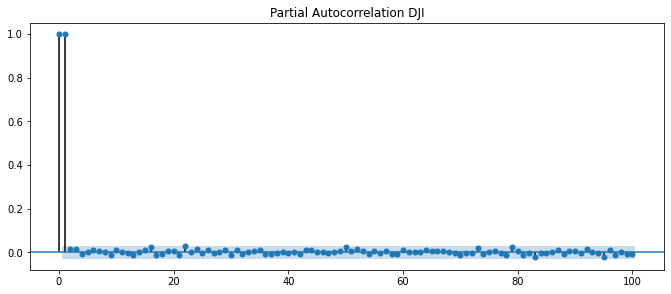

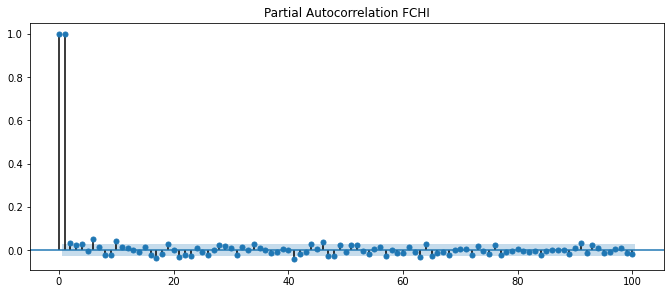

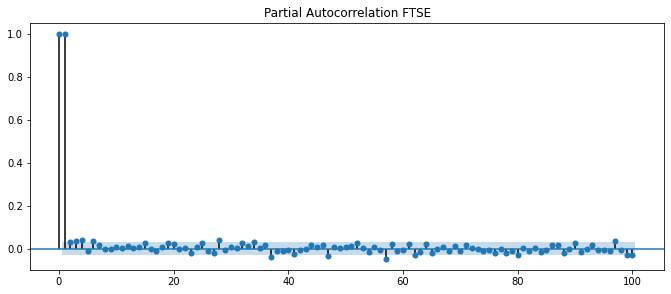

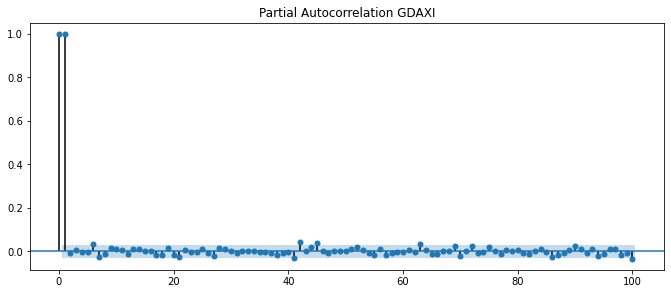

In [ ]:
plot_pacf(series_imported)

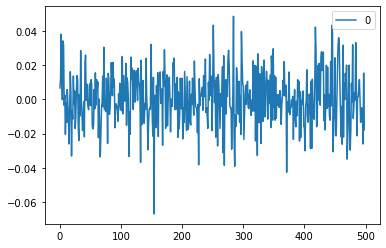

In [ ]:
pacf = sm.graphics.tsa.pacf(series_imported[1][0],nlags = 500)
pd.DataFrame(pacf[2:]).plot()

###IMM

In [ ]:
meanimm = []
for e in range(2,len(X),500):
    X,y = split_sequence(series_imported[1][1], e, delay=0)
    imm = np.mean(mutual_info_regression(X, y))
    print(imm)
    meanimm.append(imm)
pd.DataFrame(meanimm).plot()

[2.12045582 1.88649826 1.67806502 ... 0.74859782 0.7404587  0.73981296]


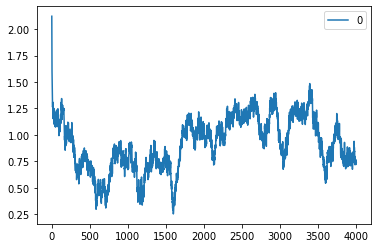

In [ ]:
X,y = split_sequence(series_imported[1][0], 4000, delay=0)
imm = (mutual_info_regression(X, y))[::-1]
print(imm)
pd.DataFrame(imm).plot()

In [ ]:
def plot_imm(series_imported):
    imm = []
    for e in range(len(series_imported[1])):
        fig = plt.figure(figsize=(25,10))
        ax1 = fig.add_subplot(222)         
        title_imm = "Mutual Information " + str(Indices[e])        
        delay, parameters = nk.complexity_delay(series_imported[1][e], delay_max=(int(len(series_imported[1][e])/2)), show=False, method="fraser1986")
        imm.append(parameters["Scores"]) 
        pd.DataFrame(parameters["Scores"]).plot(title=title_imm, fig=fig, ax=ax1)
    return imm

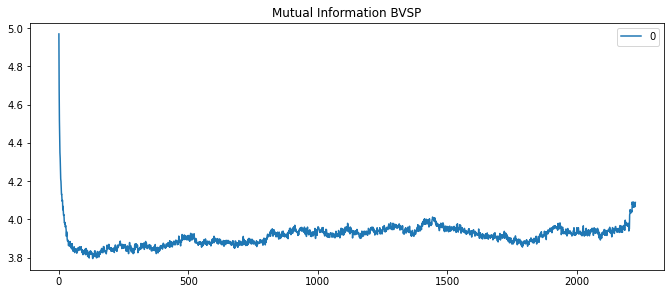

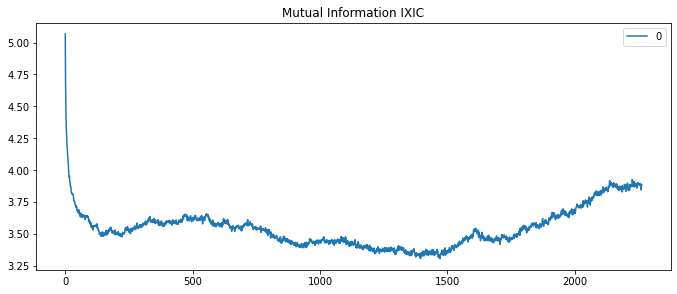

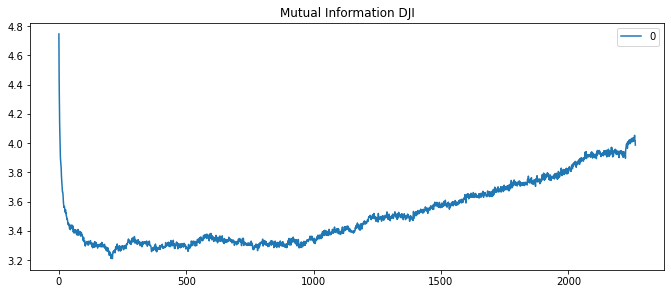

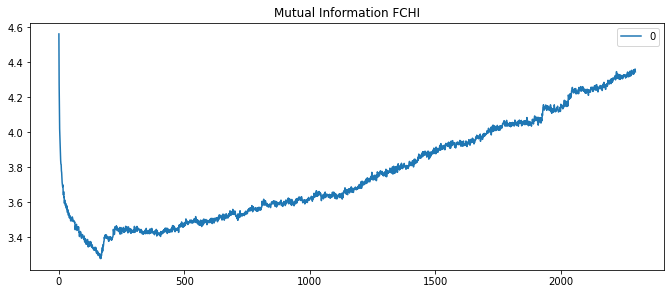

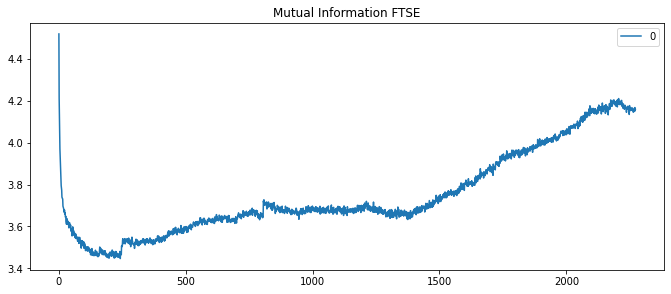

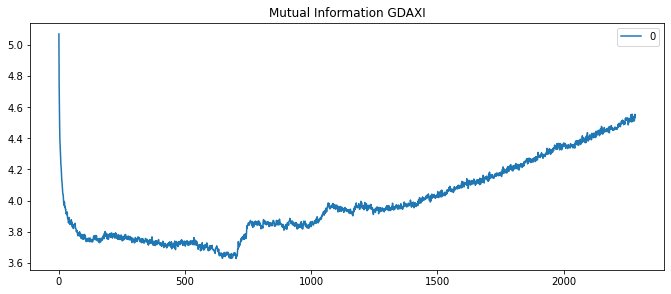

In [ ]:
imm= plot_imm(series_imported)

In [ ]:
imm_values = []
for e in imm:    
    imm_values.append(np.where(e==np.min(e))[0][0])
estatisticas["IMM(Min)"] = imm_values
estatisticas

Min           Max  length  Min  Max      Mean       Var  \
BVSP   8371.000000  76990.000000  4454.0  0.1  0.9  0.501200  0.053534   
IXIC   1114.109985   6994.759766  4528.0  0.1  0.9  0.356724  0.033166   
DJI    6547.049805  24837.509766  4528.0  0.1  0.9  0.371025  0.024943   
FCHI   2403.040039   6922.330078  4597.0  0.1  0.9  0.441905  0.026018   
FTSE   3287.000000   7687.799805  4547.0  0.1  0.9  0.542576  0.029207   
GDAXI  2202.959961  13478.860352  4571.0  0.1  0.9  0.433549  0.032021   

       Kurtosis        CA  PACF  ACF(1/e)  ACF(0)  IMM(Min)  
BVSP  -1.318223 -0.317747   2.0     818.0  1303.0       131  
IXIC   0.016069  0.990542   2.0     663.0  1224.0      1395  
DJI    0.360361  1.025210   2.0     705.0  1194.0       210  
FCHI  -0.471069  0.432049   2.0     260.0   430.0       167  
FTSE  -0.666733 -0.307828   2.0     348.0   847.0       242  
GDAXI -0.353613  0.590856   2.0     671.0  1198.0       702

In [ ]:
def mutual_information(x, y, bins=256):
    """Calculate the mutual information between two random variables.
    Calculates mutual information, I = S(x) + S(y) - S(x,y), between two random variables x and y, where S(x) is the Shannon entropy.
    """
    p_x = np.histogram(x, bins)[0]
    p_y = np.histogram(y, bins)[0]
    p_xy = np.histogram2d(x, y, bins)[0].flatten()

    p_x = p_x[p_x > 0] / np.sum(p_x)
    p_y = p_y[p_y > 0] / np.sum(p_y)
    p_xy = p_xy[p_xy > 0] / np.sum(p_xy)

    h_x = np.sum(p_x * np.log2(p_x))
    h_y = np.sum(p_y * np.log2(p_y))
    h_xy = np.sum(p_xy * np.log2(p_xy))

    return h_xy - h_x - h_y

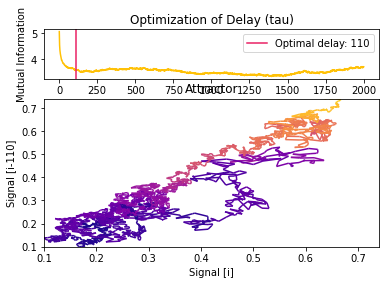

In [ ]:
delay, parameters = nk.complexity_delay(series_imported[1][1], delay_max=2000, show=True, method="fraser1986")

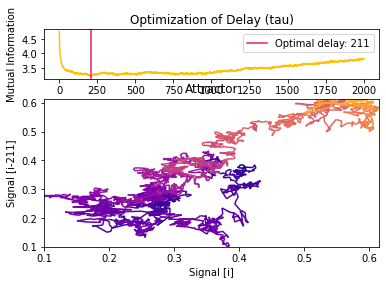

In [ ]:
delay, parameters = nk.complexity_delay(series_imported[1][2], delay_max=2000, show=True, method="fraser1986")

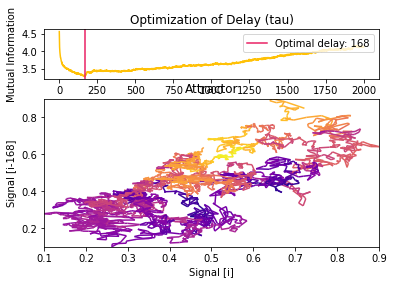

In [ ]:
delay, parameters = nk.complexity_delay(series_imported[1][3], delay_max=2000, show=True, method="fraser1986")

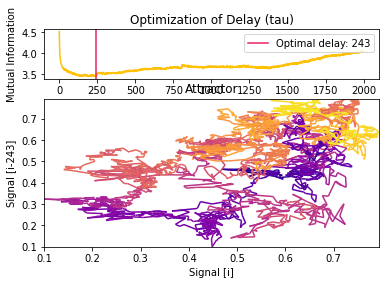

In [ ]:
delay, parameters = nk.complexity_delay(series_imported[1][4], delay_max=2000, show=True, method="fraser1986")

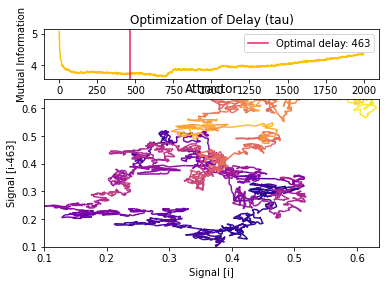

In [ ]:
delay, parameters = nk.complexity_delay(series_imported[1][5], delay_max=2000, show=True, method="fraser1986")

In [ ]:
mu=parameters['Scores']

In [ ]:
signal=df
delay, parameters = nk.complexity_delay(signal, delay_max=1000, show=True, method="fraser1986")
delay, parameters = nk.complexity_delay(signal, delay_max=1000, show=True, method="theiler1990")
delay, parameters = nk.complexity_delay(signal, delay_max=1000, show=True, method="casdagli1991")
delay, parameters = nk.complexity_delay(signal, delay_max=1000, show=True, method="rosenstein1993")
delay, parameters = nk.complexity_delay(signal, delay_max=1000, show=True, method="rosenstein1994")
delay, parameters = nk.complexity_delay(signal, delay_max=1000, show=True, method="lyle2021")

30

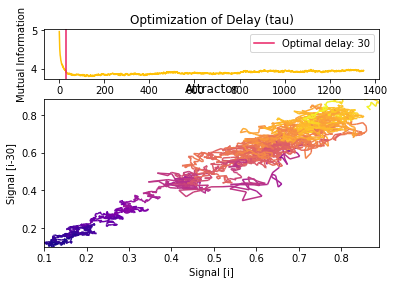

In [ ]:
nk.complexity_delay(df, delay_max=1350, método = 'casdagli1991' ,show=True)[0]

###Hurst

"Série temporal financeira possui características de 
um passeio aleatório (HP= 0.5), 
possui dependência não-linear de curto (0.5 <HP≤ 1) 
longo (0 ≤HP< 0.5) prazos (MENEZES;BARRETO; FREIRE, 2009)."


H = 0,5
Isso é indicativo de uma série browniana . Não há correlação entre as observações atuais e as observações futuras. É difícil prever valores no futuro.

H > 0,5
Isso é indicativo de uma  série temporal persistente . No curto prazo, os valores tenderão a seguir as tendências existentes. Ou seja, aqueles valores que estão aumentando estão previstos para aumentar e vice-versa.

H < 0,5
Isso é indicativo de uma série temporal Anti- Persistente . No curto prazo, os valores tenderão a ir contra as tendências existentes. Ou seja, aqueles valores que estão aumentando estão previstos para diminuir e vice-versa.

In [ ]:
#https://towardsdatascience.com/introduction-to-the-hurst-exponent-with-code-in-python-4da0414ca52e
def hurst(ts,lags):
    """
    Returns the Hurst Exponent of the time series vector ts
    """
    # make sure we are working with an array, convert if necessary
    ts = np.asarray(ts)
    # Helper variables used during calculations
    lagvec = []
    tau = []
    # Create the range of lag values
    lags = range(2, lags)
    #  Step through the different lags
    for lag in lags:
        #  produce value difference with lag
        pdiff = np.subtract(ts[lag:],ts[:-lag])
        
        #  Write the different lags into a vector
        lagvec.append(lag)
        
        #  Calculate the variance of the difference vector
        tau.append(np.sqrt(np.std(pdiff)))

    #  linear fit to double-log graph
    m = np.polyfit(np.log10(np.asarray(lagvec)),np.log10(np.asarray(tau).clip(min=0.001)),1)
    # return the calculated hurst exponent
    return m[0]*2.0

In [ ]:
hurst_exp = []
for lag in range(20,len(df),5):
    hurst_exp.append(hurst(df, lag))
pd.DataFrame(hurst_exp).plot()

In [ ]:
x=np.array([0.0000000000000000000,
0.4578589071630780000,
-1.5892053973013500000,
0.9262644728823990000,
2.4996981040937200000,
-0.3357681432610730000,
0.6206040546131500000,
-1.0220864661654200000,
0.6706231454005840000,
-1.4266344396628000000,
2.8108366724478100000,
1.9196090977837300000,
0.0513669311112297000,
-0.7872219053051910000,
2.5298988040478400000,
-0.3364737550471060000,
0.6583389601620530000,
-0.0335401643468014000,
-0.8947044679304410000,
-0.2821192800316010000,
-3.5873931986646300000,
-0.7277422383942690000,
-1.0877919006798700000,
1.6496324188631800000,
-1.1465866995942900000,
2.5636450154651500000,
-0.6089427593806150000,
-1.2895320340763200000,
1.0581072294142000000,
0.1403837154890120000,
-1.0689252336448600000,
-4.0030702013343600000,
-1.2177870717756300000,
-0.9339393562044720000,
-1.9923323486895800000,
2.0264204181095200000,
1.5587680703959900000,
-1.6524322317118400000,
3.3100497136744100000,
0.9989644880306960000,
-0.2653639708099620000,
-1.2880208018383000000,
0.4349424160744910000,
-1.0247026532479400000,
-0.6409071300918170000,
-3.6965825218631800000,
0.3671024666709540000,
-2.1753080082135500000,
-1.2069530993768400000,
1.1685811035123900000,
-2.6317516571503600000,
0.4516042059854450000,
-0.3355029188753970000,
-5.2918602302565200000,
2.6160517523281500000,
1.9189470038101900000,
0.8360522022838430000,
-1.3683855746545300000,
-2.3920174958994000000,
1.0922839938384100000,
-3.1652583460313100000,
-1.7452256634003300000,
0.8589939579238590000,
4.2439552508119800000,
0.2907983106002820000,
1.6154642733862600000,
2.2352061960730900000,
-1.5217969165337600000,
1.0122140495310000000,
-3.5005678402030800000,
-0.7476635514018670000,
4.3105252144800100000,
-3.5038448679371400000,
-5.0932021342942300000,
1.4383761682243100000,
1.2596271503635000000,
0.6752914415695250000,
4.1940266892607400000,
1.1587721081520700000,
-0.0669882100750252000,
-0.1407695401528410000,
1.6446264348526600000,
-0.3236032228239320000,
-1.4443781885642300000,
-0.8605042016806670000,
0.2169932867701840000,
1.4480005413086000000,
-3.3348896151537400000,
-1.7663699717104800000,
-0.0772634684273354000,
3.4303388162519400000,
0.5436998776675360000,
0.6083547384074570000,
1.6393442622950800000,
-1.9764674775251200000,
-0.9238653988805750000,
-1.1502858698611500000,
-1.4666391241479100000,
-0.0559049615653340000,
1.0627884211998200000,
0.2421475024214860000,
1.1111877976395900000,
0.9692832764505170000,
2.1092482422931300000,
1.9266419491525500000,
-0.4287106203312740000,
0.8806836714723820000,
-0.6337299534402430000,
-0.9241181830014320000,
-0.3349973725696230000,
1.5158505239570200000,
-2.7137570603129300000,
-4.2042042042042100000,
0.3204458376872220000,
1.1804735782237300000,
1.7294626312538600000,
-0.9512244484922050000,
-0.9671706851927530000,
-0.5502063273727600000,
-1.0511756569847800000,
0.5800950517193200000,
1.1743450767841100000,
-0.0343406593406592000,
-1.3878392305049800000,
-2.0692538145335400000,
-0.0569151963574321000,
-1.0037015945330200000,
-2.4232400949162300000,
1.7833456153279400000,
0.7529684332464590000,
1.1641276228801400000,
-1.8965762182128200000,
2.5921367026283400000,
-2.6677958924412500000,
-0.2102820680153770000,
2.3979072809184700000,
-0.1703093954016470000,
-2.3457492180835900000,
1.5868394234968700000,
-1.0461450272284300000,
0.7241129616220030000,
-1.4809489575844700000,
0.3648569760653860000,
-0.0799767340410096000,
0.5821145310339840000,
0.1085147941836120000,
1.5103338632750400000,
-0.0783085356303892000,
-0.8335708178968340000,
-0.6106760543142520000,
0.5855139511348860000,
-1.0348544735896500000,
0.4211749328298710000,
-1.2293007448116200000,
-1.0981770261366200000,
-3.4421496779924500000,
0.5443115608708910000,
-1.7003431185665300000,
0.4654049022649650000,
-1.5518838789376200000,
1.9606305387812800000,
-0.0384585801092241000,
0.1692828562634750000,
0.4532186203717980000,
-1.4146975606025800000,
-0.3955941669252280000,
-0.3192897749396460000,
-0.2578124999999990000,
-1.3785540847497500000,
-2.6685727900881500000,
-2.7172582619339100000,
-6.7857741989599000000,
-7.2617654998650200000,
-2.6392392780904300000,
5.1425154474785700000,
0.0379146919431195000,
1.8097403827932500000,
-1.8799441600744500000,
-1.1761358247178300000,
1.0941549093003200000,
-2.8861672837748000000,
-2.1800762537882500000,
3.9876074355386800000,
2.2200864968765100000,
-1.2692741632192600000,
-1.4284353871059900000,
-1.1399864747367400000,
-1.6710642040457400000,
1.3416815742397100000,
-1.0002942041777000000,
1.8722139673105400000,
1.7308440295604700000,
3.0873637927738600000,
5.0440426518312500000,
-0.6267102127283990000,
0.1154734411085380000,
-2.4487623103540000000,
3.0650295588904100000,
3.2474408753971000000,
-0.7435897435897450000,
-1.2486007061052300000,
2.2322985699337200000,
0.4861821903787030000,
-3.4292504880740200000,
-3.1027511646303900000,
3.0932510885341100000,
0.2023757149142160000,
6.8229715489989600000,
2.0632963419646500000,
1.6108247422680400000,
-0.4914394419784360000,
1.4099091922893200000,
-1.2881941717068600000,
2.7930293626163800000,
-0.7121845486917520000,
0.4444097926087580000,
0.8072653884964700000,
-2.6873026873026800000,
1.2343725272986300000,
1.7586368610286200000,
3.1108380059912300000,
2.5029797377830800000,
-1.1409883720930200000,
-4.2931706241270300000,
-2.1737460634457400000,
1.5389447236180900000,
3.1240334055057300000,
-1.4172165566886600000,
1.7874800334677100000,
1.1732177551935500000,
-1.7726567693330400000,
1.1053462666365900000,
-0.7288412910902880000,
1.6107281989811200000,
-3.0597950305979400000,
-1.4374809857012400000,
-0.3626823057334640000,
3.7561957868649200000,
-0.7986862730462010000,
-2.7990970654627500000,
3.4912525158693300000,
-0.0822799012641151000,
2.9794879472975000000,
-1.2939808083745300000,
2.1652673442333200000,
2.8330449826989600000,
0.4696810375043770000,
0.3279374825565060000,
-1.4674177620140400000])/100


In [ ]:
def my_hurst(x, lag):
    z_ajustado = []
    rs = []

    for e in range(0,1+len(x)-lag):
        #print("//")
        std = np.std(x[e:lag+1+e])  #ok
        #print("std " +str(std))
        mean = np.mean(x[e:lag+e]) #ok
        #print("mean " +str(mean))

        if e <= lag:
            z_ajustado.append(x[-1+lag+e] - mean)
            #print("z_ajustado " +str(z_ajustado[:lag+e]))
            max = np.max(np.array(z_ajustado[:lag+e]))      
            #print("max " +str(max)) 
            min = np.min(np.array(z_ajustado[:lag+e]))
            #print("min " +str(min))
        
        else:        
            z_ajustado.append(x[-1+lag+e] - mean)
            #print("z_ajustado " +str(z_ajustado[e-lag:e]))
            max = np.max(np.array(z_ajustado[e-lag:e]))       
            #print("max " +str(max)) 
            min = np.min(np.array(z_ajustado[e-lag:e]))
            #print("min " +str(min))            
        rs.append((max - min)/std)
    pd.DataFrame(rs[lag:]).plot()     
    hurst = np.log2(rs[lag:])/np.log2(range(lag,len(rs)))
    pd.DataFrame(hurst).plot()    
    print(np.mean(hurst))
    
    return rs

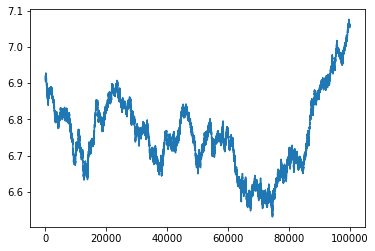

Hurst(GBM):   nan


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]


In [ ]:
from numpy import cumsum, log, polyfit, sqrt, std, subtract
from numpy.random import randn

def hurst(ts):
    """Returns the Hurst Exponent of the time series vector ts"""
    # Create the range of lag values
    lags = range(2, 4000)

    # Calculate the array of the variances of the lagged differences
    tau = [sqrt(std(subtract(ts[lag:], ts[:-lag]))) for lag in lags]

    # Use a linear fit to estimate the Hurst Exponent
    poly = polyfit(log(lags), log(tau), 1)

    # Return the Hurst exponent from the polyfit output
    return poly[0]*2.0

# Create a Gometric Brownian Motion
from numpy import cumsum, log, polyfit, sqrt, std, subtract
from numpy.random import randn
np.random.seed(0)

gbm = log(cumsum(randn(100000))+1000)
plt.plot(gbm)
plt.show()
#Calculate Hurst Exponent for GBM
print("Hurst(GBM):   %s" % hurst(df))

In [ ]:
rs = my_hurst(gbm, 15)

In [ ]:
np.polyfit(np.log(np.array(range(1,len(rs[0])+1))), np.log(rs[0]), 1)
 

In [ ]:
hurst = np.polyfit(np.log(np.array(range(1,len(rs[0][1:])+1))), np.log(rs[0][1:]), 1)
print(hurst)

In [ ]:
for e in range(10, 1000,100):
   print( my_hurst(df, e)[2])

In [ ]:
np.polyfit(np.log(np.array(range(1,len(rs[0])+1))), np.log(rs[0]), 1)

array([0.12332154, 1.5230055 ])

In [ ]:
def plot_hurst(series_imported):
    hurst_pd = []
    for e in range((len(series_imported[1]))):
      hurst = []
      for i in range(4,len(series_imported[1][e]),500):     
          valor = hurst(series_imported[1][e],i)         
          hurst.append(valor)   
      fig = plt.figure(figsize=(25,10))
      ax1 = fig.add_subplot(222)         
      title_hurst= "Hurst Exponent " + str(Indices[e])    
      pd.DataFrame(hurst).plot(title=title_hurst, fig=fig, ax=ax1)
      hurst_pd.append(pd.DataFrame(hurst))
    return hurst_pd

In [ ]:
import numpy as np
def variance_ratio(ts, lag = 2):
    """
    Returns the variance ratio test result
    """
    # make sure we are working with an array, convert if necessary
    ts = np.asarray(ts)
    
    # Apply the formula to calculate the test
    n = len(ts)
    mu  = sum(ts[1:n]-ts[:n-1])/n;
    m=(n-lag+1)*(1-lag/n);
    b=sum(np.square(ts[1:n]-ts[:n-1]-mu))/(n-1)
    t=sum(np.square(ts[lag:n]-ts[:n-lag]-lag*mu))/m
    return t/(lag*b);

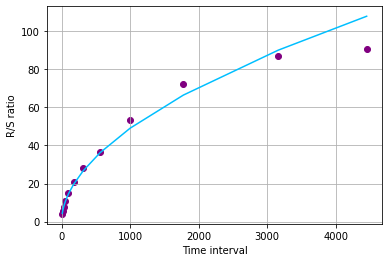

H=0.5275, c=1.2835


In [ ]:
from hurst import compute_Hc, random_walk
rw = random_walk(100000, proba=0.5, min_lookback=1, max_lookback=100, cumprod=False)

H, c, data = compute_Hc(df,  kind='random_walk' ,simplified=True)
f, ax = plt.subplots()
ax.plot(data[0], c*data[0]**H, color="deepskyblue")
ax.scatter(data[0], data[1], color="purple")
ax.set_xlabel('Time interval')
ax.set_ylabel('R/S ratio')
ax.grid(True)
plt.show()
print("H={:.4f}, c={:.4f}".format(H,c))

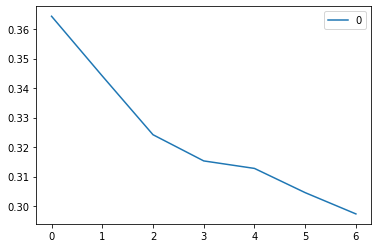

In [ ]:
pd.DataFrame(np.log(data[1])/np.log(data[0])).plot()

In [ ]:
0.8240*2000**0.5531

55.173038517118236

In [ ]:
data

[[10, 17, 31, 56, 100, 177, 316, 562, 1000, 1778, 3162, 4454],
 [2.6572762258716427,
  3.8652597760831084,
  5.4427678563978255,
  7.789371266938454,
  11.059019480371989,
  15.372137528531642,
  21.14375571336182,
  28.834587110486144,
  39.097725530114815,
  53.49420377971502,
  62.62200135016438,
  80.920787088041]]

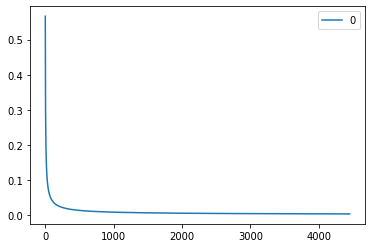

In [ ]:
rs = []
t = []
lg = []
for e in range(3,len(df)):
    t.append(e)
    rs.append(c*e**H)

rs = np.array(rs)
t = np.array(t)
pd.DataFrame(rs/t).plot()

In [ ]:
#https://github.com/erykml/medium_articles/blob/master/Time%20Series/hurst_exponent.ipynb
def get_hurst_exponent(time_series, max_lag=20):
    """Returns the Hurst Exponent of the time series"""    
    lags = range(2, max_lag)
    # variances of the lagged differences
    tau = [np.std(np.subtract(time_series[lag:], time_series[:-lag])) for lag in lags]
    #print(tau)
    # calculate the slope of the log plot -> the Hurst Exponent
    reg = np.polyfit(np.log(lags), np.log(tau), 1)
    return reg[0]

In [ ]:
def plot_hurst(series_imported):   
    e_h_df = []
    for e in range(len(Indices)):
        e_h = []
        for i in range(5,len(series_imported[1][e]),50):  
            e_h.append(get_hurst_exponent(series_imported[1][e].values, i))
        e_h_df.append(e_h)
        title_hurst= "Hurst Exponent " + str(Indices[e])     
        pd.DataFrame(e_h).plot(title=title_hurst)
    return e_h_df

In [ ]:
plot_hurst(series_imported)

In [ ]:
e_h_df = []
for e in range(len(Indices)):
    e_h = []
    for i in range(5,len(series_imported[1][e]),500):  
        e_h.append(get_hurst_exponent(series_imported[1][e].values, i))
    e_h_df.append(e_h)


In [ ]:
e_h_df[1].plot()

In [ ]:
import neurokit2 as nk
signal = nk.signal_simulate(duration=2, frequency=5)
h, info = nk.complexity_hurst(np.array(df), windows=1000,corrected=False, show=True)
h  

In [ ]:
info

{'Corrected': False,
 'Intercept': -0.40002187038241066,
 'Scores': array([0.57242278, 0.61563337, 0.65800796, 0.69105745, 0.72539255,
        0.7563959 , 0.78468124, 0.80509302, 0.8374396 , 0.8560324 ,
        0.88603084, 0.90011053, 0.91487786, 0.93968948, 0.96128566,
        0.9747182 , 0.99573667, 1.01454403, 1.02782406, 1.04280499,
        1.04943008, 1.06817441, 1.07681736, 1.09698725, 1.11296066,
        1.12421258, 1.13226534, 1.14266642, 1.16360893, 1.16373712,
        1.18532805, 1.18976096, 1.19676268, 1.20975155, 1.22808611,
        1.23010189, 1.24720411, 1.25198454, 1.2611084 , 1.27067741,
        1.27626806, 1.28613375, 1.28153406, 1.29975976, 1.3125104 ,
        1.32950329, 1.32565685, 1.33309388, 1.34402064, 1.35695388,
        1.35495563, 1.36772564, 1.36606131, 1.38816859, 1.38086816,
        1.39640296, 1.40903841, 1.41533438, 1.41675967, 1.4230423 ,
        1.43266908, 1.44478933, 1.4439246 , 1.4518977 , 1.4498661 ,
        1.46102038, 1.46973742, 1.46478335, 1.484

###LagPlots

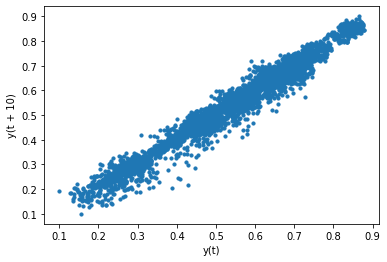

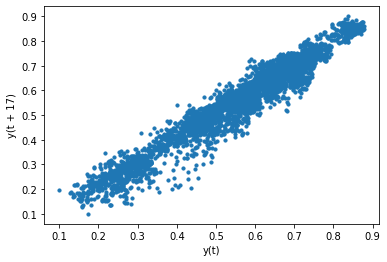

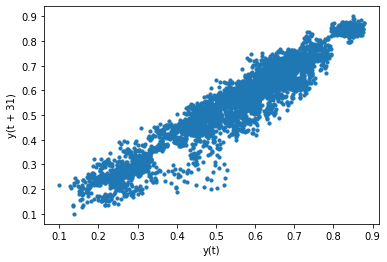

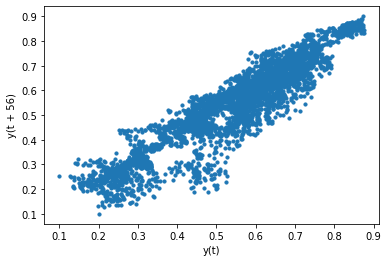

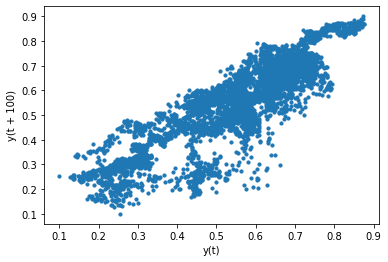

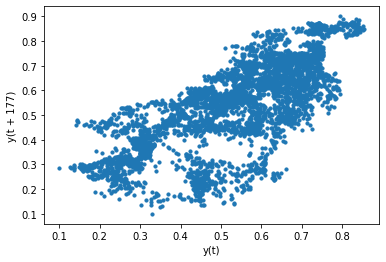

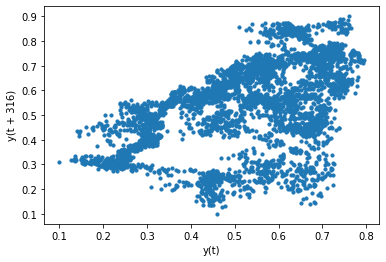

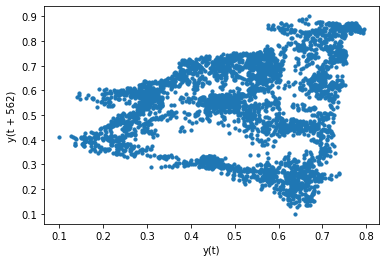

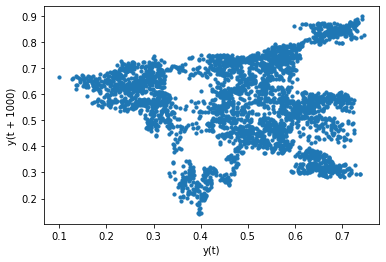

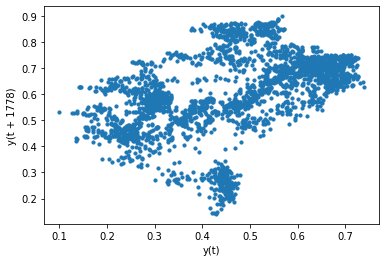

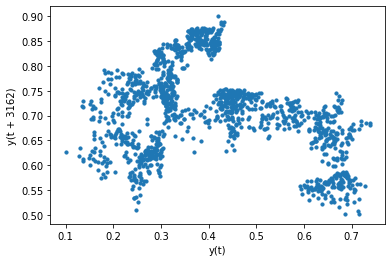

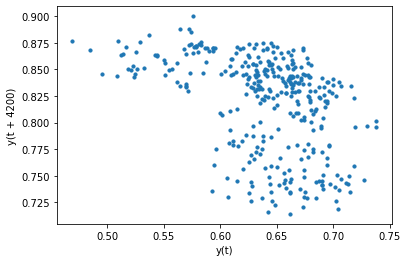

<Figure size 432x288 with 0 Axes>

In [ ]:
for e in [10, 17, 31, 56, 100, 177, 316, 562, 1000, 1778, 3162, 4200]:
    pd.plotting.lag_plot(pd.Series(series_imported[1][4]), lag=e, s=10)
    plt.figure()


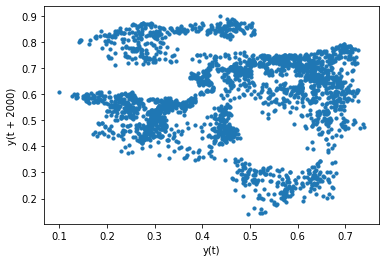

In [ ]:
pd.plotting.lag_plot(pd.Series(series_imported[1][4]), lag=2000,s=10)

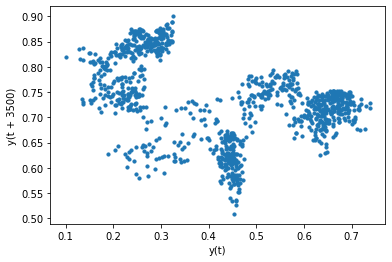

In [ ]:
pd.plotting.lag_plot(pd.Series(series_imported[1][4]), lag=3500,s=10)

In [ ]:
for lag in [20, 100, 300, 500, 1000, 2000, 4000]:
    hurst_exp = get_hurst_exponent(series.values, lag)
    print(f"Hurst exponent with {lag} lags: {hurst_exp:.4f}")

Hurst exponent with 20 lags: 0.4393
Hurst exponent with 100 lags: 0.4213
Hurst exponent with 300 lags: 0.4953
Hurst exponent with 500 lags: 0.5116
Hurst exponent with 1000 lags: 0.4477
Hurst exponent with 2000 lags: 0.2283
Hurst exponent with 4000 lags: 0.1838


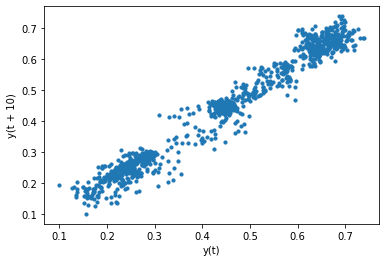

In [ ]:
pd.plotting.lag_plot(pd.Series(series_imported[1][4][:1000]), lag=10,s=10)

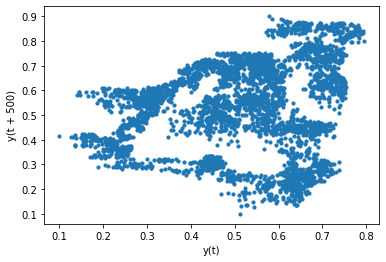

In [ ]:
pd.plotting.lag_plot(pd.Series(series_imported[1][4]), lag=500,s=10)

###ARIMA


In [64]:
real_train = import_indices(index= Indices,
            start="2000-01-01",
            end="2017-12-31",
            a=0.1,
            b=0.9)

real_valid = import_indices(index= Indices,
            start="2018-01-01",
            end="2018-12-31",
            a=0.1,
            b=0.9)

real_test = import_indices(index= Indices,
            start="2019-01-01",
            end="2019-12-31",
            a=0.1,
            b=0.9)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [65]:
train_df = pd.DataFrame(train[0])
valid_df = pd.DataFrame(valid[0])
test_df =  pd.DataFrame(test[0])
train_df.plot()
valid_df.plot()
test_df.plot()

ValueError: ignored

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(train_df.values, order=(2,1,2)).fit()
train_arima = model.predict()

pd.DataFrame(train_df).to_csv('train_df.csv')
pd.DataFrame(train_arima).to_csv('train_arima.csv')

In [ ]:
# evaluate an ARIMA model using a walk-forward validation
# split into train and valid sets

train, valid = train_df.values, valid_df.values

history = [x for x in train]
valid_predictions = list()

# walk-forward validation
for t in range(len(valid)):
    model = ARIMA(history, order=(2,1,2))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    valid_predictions.append(yhat)
    obs = valid[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
    #print((t/len(valid)))

predicted=0.892807, expected=0.910504
predicted=0.909798, expected=0.911717
predicted=0.911114, expected=0.919318
predicted=0.918753, expected=0.924262
predicted=0.923694, expected=0.927852
predicted=0.927386, expected=0.921848
predicted=0.921726, expected=0.914119
predicted=0.914292, expected=0.927689
predicted=0.927428, expected=0.927503
predicted=0.927251, expected=0.932201
predicted=0.931939, expected=0.933134
predicted=0.932895, expected=0.948954
predicted=0.948287, expected=0.946320
predicted=0.945924, expected=0.949316
predicted=0.949012, expected=0.954620
predicted=0.954237, expected=0.942997
predicted=0.943068, expected=0.977996
predicted=0.977028, expected=0.999576
predicted=0.998205, expected=0.989864
predicted=0.989584, expected=0.987346
predicted=0.987184, expected=0.992371
predicted=0.992036, expected=0.999156
predicted=0.998746, expected=0.982205
predicted=0.982356, expected=0.956789
predicted=0.957705, expected=0.980491
predicted=0.980602, expected=0.967352
predicted=0.

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=1.019504, expected=1.024315
predicted=1.023789, expected=1.015945
predicted=1.015859, expected=0.998993
predicted=0.999456, expected=0.997792
predicted=0.998233, expected=1.002257
predicted=1.002380, expected=1.005312
predicted=1.005282, expected=1.000998
predicted=1.001097, expected=0.999028
predicted=0.999175, expected=0.993210
predicted=0.993462, expected=1.009369
predicted=1.009076, expected=1.015537
predicted=1.015063, expected=1.009521


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=1.009415, expected=1.005638
predicted=1.005717, expected=0.992546
predicted=0.992957, expected=0.992056
predicted=0.992460, expected=0.980712
predicted=0.981220, expected=0.983639
predicted=0.984007, expected=0.993117
predicted=0.993023, expected=0.990680
predicted=0.990619, expected=0.986122
predicted=0.986253, expected=0.994411
predicted=0.994302, expected=0.979488
predicted=0.979736, expected=0.980258
predicted=0.980525, expected=0.997652
predicted=0.997299, expected=0.989491
predicted=0.989351, expected=0.988990
predicted=0.989046, expected=0.985924
predicted=0.986018, expected=0.995834
predicted=0.995657, expected=0.991287
predicted=0.991187, expected=0.973647
predicted=0.974147, expected=0.987673
predicted=0.987749, expected=0.996253
predicted=0.995873, expected=0.998562


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=0.998265, expected=0.985621
predicted=0.985801, expected=0.968459
predicted=0.969146, expected=0.982729
predicted=0.982964, expected=1.002432
predicted=1.001826, expected=1.002992
predicted=1.002370, expected=0.999797
predicted=0.999544, expected=1.000404
predicted=1.000292, expected=0.998853
predicted=0.998803, expected=0.993898
predicted=0.994018, expected=1.009509
predicted=1.009278, expected=1.010232
predicted=1.009792, expected=1.006385
predicted=1.006281, expected=0.988104
predicted=0.988530, expected=0.973426


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=0.974323, expected=0.971444
predicted=0.972200, expected=0.966734
predicted=0.967264, expected=0.969555
predicted=0.969893, expected=0.984816
predicted=0.984610, expected=1.003423


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=1.002635, expected=0.995950
predicted=0.995361, expected=0.996090
predicted=0.995943, expected=0.994901
predicted=0.994773, expected=1.011304
predicted=1.010910, expected=0.977320
predicted=0.977829, expected=0.971024
predicted=0.972008, expected=0.956253
predicted=0.957181, expected=0.967025
predicted=0.967424, expected=0.945200
predicted=0.945992, expected=0.936515
predicted=0.937470, expected=0.922245
predicted=0.923149, expected=0.880950
predicted=0.882071, expected=0.889297
predicted=0.890500, expected=0.897249
predicted=0.897376, expected=0.902915


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=0.902869, expected=0.918724
predicted=0.918310, expected=0.895943
predicted=0.896106, expected=0.889822
predicted=0.890409, expected=0.863404
predicted=0.864323, expected=0.852806
predicted=0.853450, expected=0.845415
predicted=0.845910, expected=0.850614
predicted=0.850823, expected=0.843246
predicted=0.843582, expected=0.835073
predicted=0.835369, expected=0.827344
predicted=0.827654, expected=0.816350
predicted=0.816725, expected=0.834759
predicted=0.834652, expected=0.843258
predicted=0.842988, expected=0.819381
predicted=0.819660, expected=0.825980
predicted=0.826096, expected=0.829617
predicted=0.829567, expected=0.834887
predicted=0.834757, expected=0.825607
predicted=0.825695, expected=0.839107
predicted=0.838929, expected=0.850719
predicted=0.850150, expected=0.851617
predicted=0.851368, expected=0.861270
predicted=0.860957, expected=0.873803
predicted=0.873367, expected=0.871588
predicted=0.871355, expected=0.876916
predicted=0.876710, expected=0.875191
predicted=0.

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=0.930823, expected=0.951822
predicted=0.951390, expected=0.947345
predicted=0.947123, expected=0.939138
predicted=0.939204, expected=0.925206
predicted=0.925533, expected=0.920729
predicted=0.921039, expected=0.894451
predicted=0.895107, expected=0.905899
predicted=0.906135, expected=0.918794
predicted=0.918648, expected=0.901026
predicted=0.901258, expected=0.898006
predicted=0.898269, expected=0.888796
predicted=0.889112, expected=0.892282
predicted=0.892428, expected=0.878898
predicted=0.879223, expected=0.898974
predicted=0.898806, expected=0.884191
predicted=0.884362, expected=0.891513
predicted=0.891595, expected=0.910959
predicted=0.910521, expected=0.905631
predicted=0.905456, expected=0.916310
predicted=0.915986, expected=0.893168
predicted=0.893386, expected=0.896363
predicted=0.896472, expected=0.890708
predicted=0.890934, expected=0.873442
predicted=0.873936, expected=0.877872
predicted=0.878299, expected=0.893308
predicted=0.893109, expected=0.893541
predicted=0.

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=0.953158, expected=0.973251
predicted=0.972371, expected=0.969520
predicted=0.969038, expected=0.962164
predicted=0.962040, expected=1.006023
predicted=1.005000, expected=1.006070
predicted=1.004879, expected=0.977984
predicted=0.978043, expected=0.969147
predicted=0.969793, expected=0.974265
predicted=0.974571, expected=1.001756
predicted=1.001240, expected=1.002292
predicted=1.001445, expected=0.979943
predicted=0.979986, expected=0.984292
predicted=0.984576, expected=1.000345
predicted=1.000071, expected=0.996883
predicted=0.996620, expected=0.970814
predicted=0.971314, expected=0.982706
predicted=0.983040, expected=1.001779
predicted=1.001318, expected=0.979360
predicted=0.979021, expected=1.015373
predicted=1.015010, expected=1.021646
predicted=1.020768, expected=1.033246
predicted=1.032328, expected=1.046991
predicted=1.046002, expected=1.036161
predicted=1.035898, expected=1.025027
predicted=1.025272, expected=1.000614
predicted=1.001411, expected=1.000858
predicted=1.

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=1.026271, expected=1.021949
predicted=1.021810, expected=1.009707
predicted=1.009950, expected=1.012156
predicted=1.012521, expected=1.001243
predicted=1.001567, expected=0.996521
predicted=0.997116, expected=1.001511
predicted=1.001699, expected=0.994971
predicted=0.995161, expected=0.998748
predicted=0.998961, expected=1.027044


In [63]:
# evaluate forecasts
valid = pd.DataFrame(valid)[0]
valid_predictions = pd.DataFrame(valid_predictions)[0]
evaluate_all(valid,valid_predictions)

NameError: ignored

In [ ]:
pd.DataFrame(valid).to_csv('valid.csv')
pd.DataFrame(valid_predictions).to_csv('valid_predictions.csv')

# plot forecasts against actual outcomes
pyplot.plot(valid)
pyplot.plot(valid_predictions, color='red')
pyplot.show()

In [ ]:
# evaluate an ARIMA model using a walk-forward validation

# split into train and test sets

train, test = train_df.values, test_df.values

history = [x for x in train]
test_predictions = list()

# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(2,1,2))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    test_predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))
    print(t/len(test))

In [ ]:
# evaluate forecasts
evaluate_all(pd.DataFrame(test),pd.DataFrame(test_predictions))

pd.DataFrame(test).to_csv('test.csv')
pd.DataFrame(test_predictions).to_csv('test_predictions.csv')


# plot forecasts against actual outcomes
pyplot.plot(test)
pyplot.plot(test_predictions, color='red')
pyplot.show()

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import pmdarima as pm
df = pd.DataFrame(train)
model = pm.auto_arima(df.values, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-29467.203, Time=3.64 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-29468.088, Time=0.67 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-29468.145, Time=0.68 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-29468.189, Time=1.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-29468.708, Time=0.33 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-29466.162, Time=2.74 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 9.235 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 4454
Model:               SARIMAX(0, 1, 0)   Log Likelihood               14735.354
Date:                Mon, 09 May 2022   AIC                         -29468.708
Time:                        05:29:53   BIC                         -29462.306
Sample:                             0   HQIC                        -29466.45

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 4454
Model:                 ARIMA(5, 1, 5)   Log Likelihood               14743.878
Date:                Mon, 09 May 2022   AIC                         -29465.756
Time:                        06:03:56   BIC                         -29395.341
Sample:                             0   HQIC                        -29440.931
                               - 4454                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2056      1.271      0.162      0.872      -2.285       2.697
ar.L2         -0.1327      1.125     -0.118      0.906      -2.338       2.073
ar.L3          0.0643      0.503      0.128      0.8

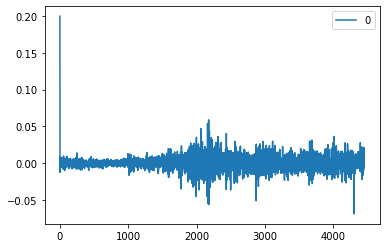

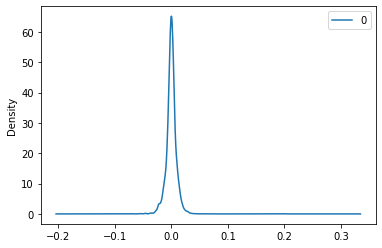

                 0
count  4454.000000
mean      0.000222
std       0.009318
min      -0.069072
25%      -0.003785
50%       0.000264
75%       0.004365
max       0.199786


In [ ]:
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd

# fit model
model = ARIMA((train).values, order=(5,1,5))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

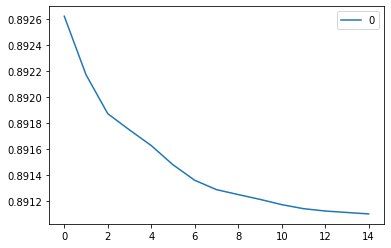

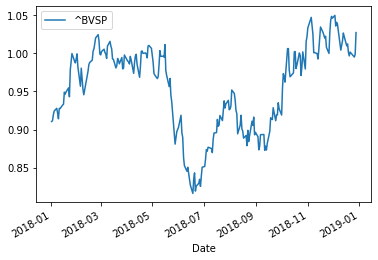

In [ ]:
start= len(train)
end= len(train)+len(valid)

predict = model_fit.forecast(15, alpha=0.05)
predict = pd.DataFrame(predict)
predict.plot()
valid.plot()

In [ ]:
import pmdarima
from pmdarima.arima.utils import ndiffs
df = train
y = train.values

## Adf Test
print(ndiffs(y, test='adf'))  # 2

# KPSS test
print(ndiffs(y, test='kpss') ) # 0

# PP test:
print(ndiffs(y, test='pp'))  # 2

1
1
1


In [ ]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(train.value.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(df.value.diff().dropna(), ax=axes[1])

plt.show()

In [ ]:
from statsmodels.tsa.arima_model import ARIMA

# 1,1,2 ARIMA Model
model = ARIMA(df.value, order=(2,1,2))
model_fit = model.fit()
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                   30
Model:                 ARIMA(2, 1, 2)   Log Likelihood                  10.649
Method:                       css-mle   S.D. of innovations              0.163
Date:                Sun, 01 May 2022   AIC                             -9.299
Time:                        22:54:43   BIC                             -0.892
Sample:                             1   HQIC                            -6.609
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.1564      0.033      4.741      0.000       0.092       0.221
ar.L1.D.value    -0.0830      0.187     -0.444      0.661      -0.450       0.284
ar.L2.D.value    -0.9231      0.105     

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  interval : int
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:1441: RuntimeWarning: invalid value encountered in sqrt


In [ ]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

###MLP

In [ ]:
train_data = pd.read_csv('train_df.csv')
train_arima = pd.read_csv('train_arima.csv')

valid_data = pd.read_csv('valid.csv')
valid_arima = pd.read_csv('valid_predictions.csv')

test_data =  pd.read_csv('test.csv')
test_arima = pd.read_csv('test_predictions.csv')

In [ ]:
train_resid_arima = pd.Series(train_data["^BVSP"][:-1]) - pd.Series(train_arima["0"][1:])
train_resid_arima = (train_resid_arima[1:])[:-1]

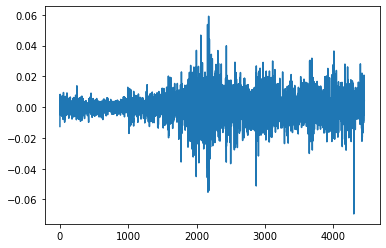

In [ ]:
train_resid_arima.plot()

In [ ]:
valid_resid_arima = pd.Series(valid_data["0"][:-1]) - pd.Series(valid_arima["0"][1:])
valid_resid_arima = (valid_resid_arima[1:])[:-1]

In [ ]:
test_resid_arima = pd.Series(test_data["0"][:-1]) - pd.Series(test_arima["0"][1:])
test_resid_arima = (test_resid_arima[1:])[:-1]

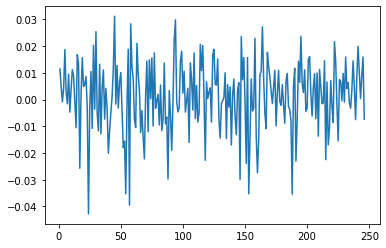

In [ ]:
test_resid_arima.plot()

In [ ]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense

Time_Lag = 100

def mlp(Time_Lag):
  # define model
  mlp = Sequential()
  mlp.add(Dense(Time_Lag, activation='sigmoid', input_dim=Time_Lag))
  mlp.add(Dense(round(2*np.sqrt(3*Time_Lag))))
  mlp.add(Dense(1))
  mlp.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.01, decay=1e-6),
              loss = "mse")
  return mlp

valid_window  = train_resid_arima[-Time_Lag:]
valid_window.append(valid_resid_arima)

test_window  = valid_resid_arima[-Time_Lag:]
test_window.append(test_resid_arima)

model= mlp(round(100)) 
X, y = split_sequence_takens(train_resid_arima, tau=1, dy=Time_Lag, diff=False, delay=0)  
X_val, y_val = split_sequence_takens(valid_window, tau=1, dy=Time_Lag, diff=False, delay=0)  
X_test, y_test= split_sequence_takens(test_window, tau=1, dy=Time_Lag, diff=False, delay=0)  



es = tf.keras.callbacks.EarlyStopping(monitor='loss', verbose=1, patience=30)
mc = tf.keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

X = X.reshape((X.shape[0], X.shape[1]))  
history=model.fit(X, y, 
                    verbose=1,
                    epochs=200, 
                    validation_data=(X_val, y_val),
                    callbacks=[tensorboard_callback,es]
                    )

Epoch 1/200
136/136 [==============================] - 1s 3ms/step - loss: 0.4499
Epoch 2/200
136/136 [==============================] - 1s 4ms/step - loss: 1.9198e-04
Epoch 3/200
136/136 [==============================] - 0s 3ms/step - loss: 1.5502e-04
Epoch 4/200
136/136 [==============================] - 0s 3ms/step - loss: 1.1042e-04
Epoch 5/200
136/136 [==============================] - 0s 3ms/step - loss: 9.8312e-05
Epoch 6/200
136/136 [==============================] - 0s 3ms/step - loss: 9.1600e-05
Epoch 7/200
136/136 [==============================] - 0s 3ms/step - loss: 9.3188e-05
Epoch 8/200
136/136 [==============================] - 0s 3ms/step - loss: 9.7552e-05
Epoch 9/200
136/136 [==============================] - 0s 4ms/step - loss: 9.2185e-05
Epoch 10/200
136/136 [==============================] - 0s 3ms/step - loss: 9.1957e-05
Epoch 11/200
136/136 [==============================] - 0s 3ms/step - loss: 9.6748e-05
Epoch 12/200
136/136 [==============================] - 

In [ ]:
model.predict(X_val, verbose=0)

In [ ]:
  #Testing Model
  print("Forecasting Train Data")
  real_train , pred_train = forecasting(model, (train), dy=Time_Lag , diff=False, tau=1, delay=0 )
  
  print("Forecasting Valid Data")
  real_valid , pred_valid = forecasting(model, (valid), dy=Time_Lag , diff=False, tau=1, delay=0 )
  print("Forecasting Test Data")
  real_test  , pred_test  = forecasting(model, (test),  dy=Time_Lag , diff=False, tau=1, delay=0 )

In [ ]:
def resultados(ts=('^BVSP'), 
               model = "mlp",
               period = "7d",
               interval = "1m",
               epochs=10000, 
               patience = 10,
               delay=1,
               diff=False
               ):
  
  
  #Normalização MinMax
  train , min, max = MinMax(train)
  valid = MinMax_valid_test(valid,min,max)
  test = MinMax_valid_test(test,min,max)

  #Diferenciação
  #train = diff(train_)
  #valid = diff(valid_)
  #test = diff(test_)

  print("Normalização concluida")
  if False: 
    plt.plot(train, 'g', label='Train')
    plt.plot(valid, 'b', label='Validação')
    plt.plot(test, 'c', label='Test')
    plt.title('Train, Validation and Test')
    plt.show()

  #Index Data
  print("Divisão dos dados em Treino, validação e teste")

  #Teste de Estacionariedade(ADF)  
  #adf((df - df.shift()))

  #Model
  if model == "narx":
     model=narx(round(dy))
  elif model == 'narx2':
     model= narx2(round(dy))
  elif model == 'mlp':
     model= mlp(round(dy))  
  elif model == 'lstm':
     model= lstm(round(dy))
  
  print("Load Model")
  
  #Time Series Split Rolling Window
  X, y =           split_sequence_takens( train, tau, dy, diff, delay  )   
  X_val, y_val =   split_sequence_takens( valid, tau, dy, diff, delay  ) 
  X_test, y_test = split_sequence_takens( test,  tau, dy, diff, delay=0) 
  print("Rolling Window")

  es = tf.keras.callbacks.EarlyStopping(monitor='loss', verbose=1, patience=patience)
  mc = tf.keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

  print("Train Model")
  #Train Model With (Error stabilization stop criterion)
  X = X.reshape((X.shape[0], X.shape[1]))  
  history=model.fit(X, y, 
                    verbose=1,
                    epochs=epochs, 
                    validation_data=(X_val, y_val),
                    callbacks=[tensorboard_callback,es]
                    )

  #Testing Model
  print("Forecasting Train Data")
  real_train , pred_train = forecasting(model, (train), dy , diff, tau=1, delay=0 )
  print("Forecasting Valid Data")
  real_valid , pred_valid = forecasting(model, (valid), dy , diff, tau=1, delay=0 )
  print("Forecasting Test Data")
  real_test  , pred_test  = forecasting(model, (test),  dy , diff, tau=1, delay=0 )

  #Results
  print("Resultados")
  plot_results(real_train, pred_train,  name='Train Dataset')
  plot_results(real_valid, pred_valid, name='Valid Dataset')
  plot_results(real_test,  pred_test,  name='Test  Dataset')

  return real_test,pred_test,history,model

#Model

In [ ]:
%tensorboard --logdir $logdir_run

##Narx2

In [ ]:
import tensorflow as tf
import keras
from keras.layers import SimpleRNN
from keras.models import Sequential
from keras.layers import Dense

def narx2(Time_Lag):
  # define model
  narx2 = Sequential()
  narx2.add(SimpleRNN(round(Time_Lag), 
                      input_shape=(Time_Lag, 1), 
                      activation=keras.activations.sigmoid,
                      unroll =True
                      ))                      
  
  narx2.add(Dense(round(2*np.sqrt(3*Time_Lag)), activation=keras.activations.linear))
  narx2.add(Dense(1))
  narx2.compile(optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.01), 
              loss = "mse")
  return narx2

In [ ]:
result= resultados(
               model = "narx2",
               ts=('^BVSP'), 
               period = "7d",
               interval = "1m",
               epochs=100, 
               patience = 15,
               delay=0,
               diff=False
              )

[*********************100%***********************]  1 of 1 completed
Importação da série temporal concluida
Tau = 1
Dy = 180
Dy2 = 7
Data Train, Data Validation and Data Test
Normalização concluida
Divisão dos dados em Treino, validação e teste
Load Model
Rolling Window
Train Model
Epoch 1/1000
59/59 [==============================] - 31s 179ms/step - loss: 0.7752 - val_loss: 0.1841
Epoch 2/1000
59/59 [==============================] - 6s 106ms/step - loss: 0.0437 - val_loss: 0.2025
Epoch 3/1000
59/59 [==============================] - 4s 67ms/step - loss: 0.0414 - val_loss: 0.1726
Epoch 4/1000
59/59 [==============================] - 4s 68ms/step - loss: 0.0391 - val_loss: 0.1309
Epoch 5/1000
59/59 [==============================] - 4s 68ms/step - loss: 0.0375 - val_loss: 0.1639
Epoch 6/1000
59/59 [==============================] - 4s 67ms/step - loss: 0.0353 - val_loss: 0.1810
Epoch 7/1000
59/59 [==============================] - 4s 68ms/step - loss: 0.0330 - val_loss: 0.2067
Epoch 8

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars


MSE: (Mean Squared Error) 0.00045283936940761704
MAE: Mean Absolute Error 0.015524276636162673
RMSE: (Root Mean Square Error): 0.02128002277742242
MAPE (Mean Absolute Percentage Error): 0.6398977014391833
POCID (Prediction of Change in Direction): 0.47843137254901963
R2 (Coeficiente de Determinação): 0.9112104804944183
Theil’s U1 : 0.10765575348559636
Theil’s U2 : 0.6689998322037227
Forecasting Test Data
MSE: (Mean Squared Error) 0.0002729659138854553
MAE: Mean Absolute Error 0.014406020946234697
RMSE: (Root Mean Square Error): 0.01652168011690867
MAPE (Mean Absolute Percentage Error): 0.3895789209357679
POCID (Prediction of Change in Direction): 0.49411764705882355
R2 (Coeficiente de Determinação): 0.9836145456114824
Theil’s U1 : 0.06304929232355323
Theil’s U2 : 2.6755949001394455
Resultados


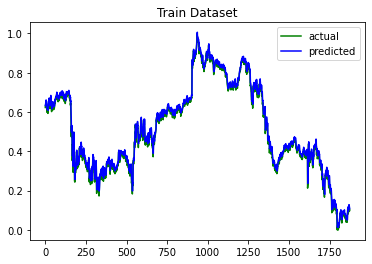

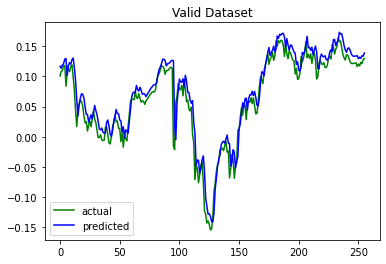

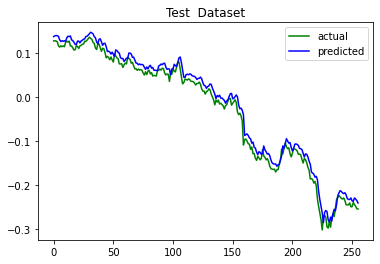

In [ ]:
#Narx-Takens with diff
result= resultados(
               model = "narx2",
               ts=('^BVSP'), 
               period = "7d",
               interval = "1m",
               epochs=1000, 
               patience = 25,
               delay=0,
               diff=False
              )

In [ ]:
import tensorflow as tf
import keras
from keras.layers import SimpleRNN
from keras.models import Sequential
from keras.layers import Dense

Time_Lag = 100
# define model
narx2 = Sequential()
narx2.add(SimpleRNN(round(Time_Lag), 
                    input_shape=(Time_Lag, 2), 
                    activation=keras.activations.sigmoid,
                    return_sequences=True
                    ))

narx2.add(SimpleRNN(round(Time_Lag), 
                    input_shape=(Time_Lag, 2), 
                    activation=keras.activations.sigmoid,
                    return_sequences=True
                    ))

narx2.add(SimpleRNN(round(Time_Lag), 
                    input_shape=(Time_Lag, 2), 
                    activation=keras.activations.sigmoid,
                    return_sequences=False
                    ))

narx2.add(Dense(round(Time_Lag), activation=keras.activations.linear))
narx2.add(Dense(1))
narx2.compile(optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.01),loss = "mse")
narx2.summary()


Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_24 (SimpleRNN)   (None, 100, 100)          10300     
                                                                 
 simple_rnn_25 (SimpleRNN)   (None, 100, 100)          20100     
                                                                 
 simple_rnn_26 (SimpleRNN)   (None, 100)               20100     
                                                                 
 dense_56 (Dense)            (None, 100)               10100     
                                                                 
 dense_57 (Dense)            (None, 1)                 101       
                                                                 
Total params: 60,701
Trainable params: 60,701
Non-trainable params: 0
_________________________________________________________________


###Série Diferenciada

In [ ]:
#Narx-Takens with diff
result= resultados(
               model = "narx2",
               ts=('^BVSP'), 
               period = "7d",
               interval = "1m",
               epochs=1000, 
               patience = 25,
               delay=0,
               diff=True
              )

[*********************100%***********************]  1 of 1 completed
Importação da série temporal concluida
Tau = 1
Dy = 190
Dy2 = 5
Data Train, Data Validation and Data Test
Normalização concluida
Divisão dos dados em Treino, validação e teste
Load Model
Rolling Window
Train Model
Epoch 1/1000
40/40 [==============================] - 7s 140ms/step - loss: 1.3959 - val_loss: 5.7780e-04
Epoch 2/1000
40/40 [==============================] - 4s 112ms/step - loss: 5.1119e-04 - val_loss: 6.5009e-04
Epoch 3/1000
40/40 [==============================] - 3s 83ms/step - loss: 4.9454e-04 - val_loss: 7.1810e-04
Epoch 4/1000
40/40 [==============================] - 3s 82ms/step - loss: 5.1056e-04 - val_loss: 5.7637e-04
Epoch 5/1000
40/40 [==============================] - 3s 81ms/step - loss: 4.9322e-04 - val_loss: 5.8377e-04
Epoch 6/1000
40/40 [==============================] - 3s 82ms/step - loss: 5.0154e-04 - val_loss: 5.9622e-04
Epoch 7/1000
40/40 [==============================] - 3s 82ms/ste

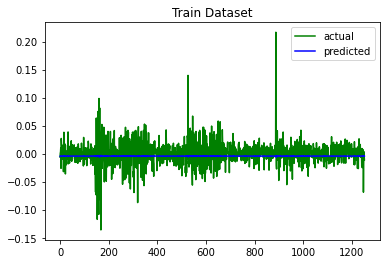

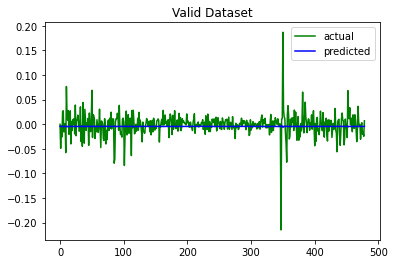

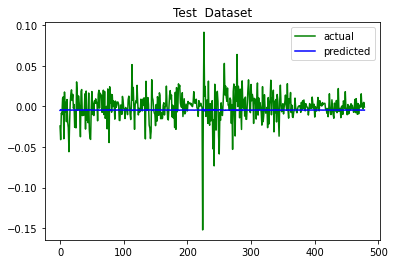

In [ ]:
result= resultados(
               model = "narx2",
               ts=('^BVSP'), 
               period = "7d",
               interval = "1m",
               epochs=1000, 
               patience = 25,
               delay=0,
               diff=True
              )

###Série não Diferenciada

[*********************100%***********************]  1 of 1 completed
Importação da série temporal concluida
Tau = 1
Dy = 200
Dy2 = 6
Data Train, Data Validation and Data Test
Normalização concluida
Divisão dos dados em Treino, validação e teste
Load Model
Rolling Window
Train Model
Epoch 1/1000
42/42 [==============================] - 14s 104ms/step - loss: 1.2105 - val_loss: 0.1695
Epoch 2/1000
42/42 [==============================] - 2s 55ms/step - loss: 0.0568 - val_loss: 0.1015
Epoch 3/1000
42/42 [==============================] - 3s 62ms/step - loss: 0.0542 - val_loss: 0.1097
Epoch 4/1000
42/42 [==============================] - 3s 63ms/step - loss: 0.0530 - val_loss: 0.1373
Epoch 5/1000
42/42 [==============================] - 2s 55ms/step - loss: 0.0507 - val_loss: 0.1004
Epoch 6/1000
42/42 [==============================] - 2s 55ms/step - loss: 0.0469 - val_loss: 0.1199
Epoch 7/1000
42/42 [==============================] - 2s 55ms/step - loss: 0.0453 - val_loss: 0.0619
Epoch 8/

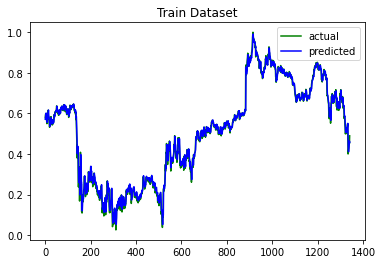

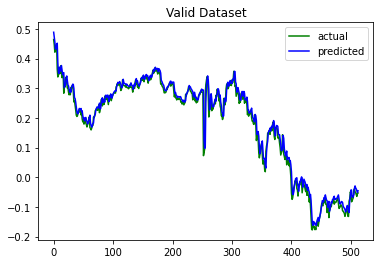

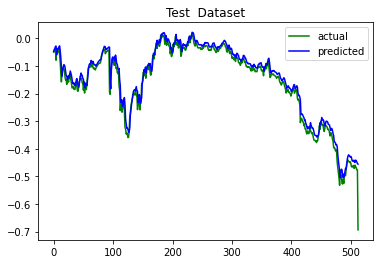

In [ ]:
result= resultados(
               model = "narx2",
               ts=('^BVSP'), 
               period = "7d",
               interval = "1m",
               epochs=1000, 
               patience = 5,
               delay=0,
               diff=False
              )

[*********************100%***********************]  1 of 1 completed
Importação da série temporal concluida
Tau = 1
Dy = 188
Dy2 = 4
Data Train, Data Validation and Data Test
Normalização concluida
Divisão dos dados em Treino, validação e teste
Load Model
Rolling Window
Train Model
Epoch 1/1000
39/39 [==============================] - 6s 111ms/step - loss: 1.0590 - val_loss: 0.0370
Epoch 2/1000
39/39 [==============================] - 3s 84ms/step - loss: 0.0499 - val_loss: 0.0566
Epoch 3/1000
39/39 [==============================] - 3s 84ms/step - loss: 0.0464 - val_loss: 0.0229
Epoch 4/1000
39/39 [==============================] - 4s 90ms/step - loss: 0.0455 - val_loss: 0.0328
Epoch 5/1000
39/39 [==============================] - 3s 84ms/step - loss: 0.0420 - val_loss: 0.0508
Epoch 6/1000
39/39 [==============================] - 3s 84ms/step - loss: 0.0415 - val_loss: 0.0503
Epoch 7/1000
39/39 [==============================] - 3s 84ms/step - loss: 0.0380 - val_loss: 0.0334
Epoch 8/1

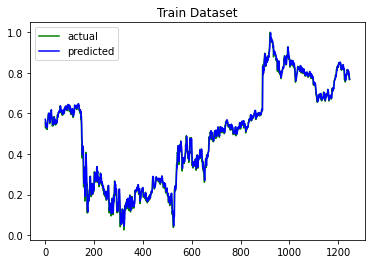

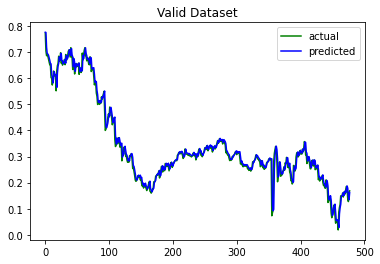

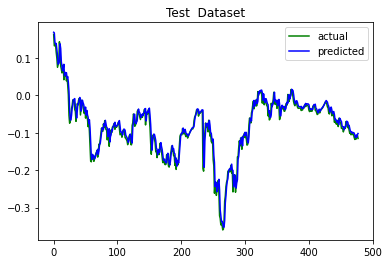

In [ ]:
result= resultados(
               model = "narx2",
               ts=('^BVSP'), 
               period = "7d",
               interval = "1m",
               epochs=1000, 
               patience = 25,
               delay=0,
               diff=False
              )

In [ ]:
result= resultados(
               model = "narx2",
               ts=('BTC-USD'), 
               period = "3d",
               interval = "1m",
               epochs=100, 
               patience = 25,
               delay=0,
               diff=False
              )

NameError: ignored

[*********************100%***********************]  1 of 1 completed
Importação da série temporal concluida
Tau = 1
Dy = 143
Dy2 = 5
Data Train, Data Validation and Data Test
Normalização concluida
Divisão dos dados em Treino, validação e teste
Load Model
Rolling Window
Train Model
Epoch 1/1000
43/43 [==============================] - 5s 97ms/step - loss: 0.5153 - val_loss: 0.0347
Epoch 2/1000
43/43 [==============================] - 2s 43ms/step - loss: 0.0232 - val_loss: 0.0248
Epoch 3/1000
43/43 [==============================] - 2s 43ms/step - loss: 0.0228 - val_loss: 0.0431
Epoch 4/1000
43/43 [==============================] - 2s 45ms/step - loss: 0.0220 - val_loss: 0.0414
Epoch 5/1000
43/43 [==============================] - 2s 44ms/step - loss: 0.0216 - val_loss: 0.0646
Epoch 6/1000
43/43 [==============================] - 2s 44ms/step - loss: 0.0204 - val_loss: 0.0460
Epoch 7/1000
43/43 [==============================] - 2s 45ms/step - loss: 0.0204 - val_loss: 0.0424
Epoch 8/10

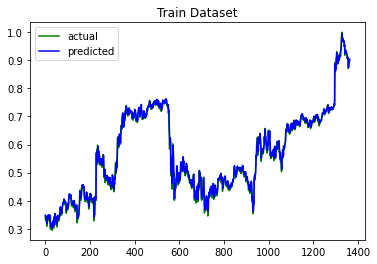

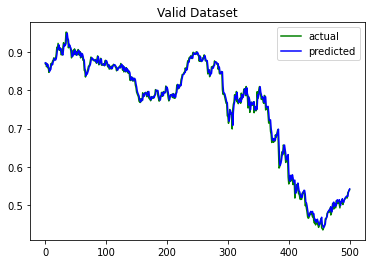

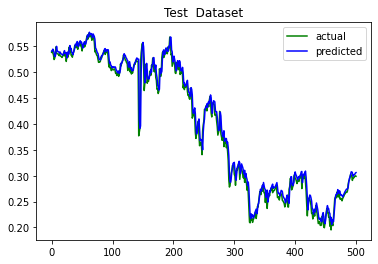

In [ ]:
result= resultados(
               model = "narx2",
               ts=('^BVSP'), 
               period = "7d",
               interval = "1m",
               epochs=1000, 
               patience = 25,
               delay=0,
              )

[*********************100%***********************]  1 of 1 completed
Importação da série temporal concluida
Tau = 1
Dy = 115
Dy2 = 4
Data Train, Data Validation and Data Test
Normalização concluida
Divisão dos dados em Treino, validação e teste
Load Model
Rolling Window
Train Model
Epoch 1/1000
17/17 [==============================] - 1s 44ms/step - loss: 0.7842 - val_loss: 0.0512
Epoch 2/1000
17/17 [==============================] - 1s 33ms/step - loss: 0.0502 - val_loss: 0.2381
Epoch 3/1000
17/17 [==============================] - 1s 37ms/step - loss: 0.0472 - val_loss: 0.0965
Epoch 4/1000
17/17 [==============================] - 1s 34ms/step - loss: 0.0435 - val_loss: 0.1185
Epoch 5/1000
17/17 [==============================] - 1s 38ms/step - loss: 0.0426 - val_loss: 0.0927
Epoch 6/1000
17/17 [==============================] - 1s 31ms/step - loss: 0.0412 - val_loss: 0.1064
Epoch 7/1000
17/17 [==============================] - 1s 33ms/step - loss: 0.0396 - val_loss: 0.0242
Epoch 8/10

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars


MSE: (Mean Squared Error) 0.0004261122305886328
MAE: Mean Absolute Error 0.016600312390367314
RMSE: (Root Mean Square Error): 0.020642486056399137
MAPE (Mean Absolute Percentage Error): 0.05755978239356239
POCID (Prediction of Change in Direction): 0.5467289719626168
R2 (Coeficiente de Determinação): 0.8849739958273388
Theil’s U1 : 0.032943534554235605
Theil’s U2 : 1.0585626189710693
Resultados


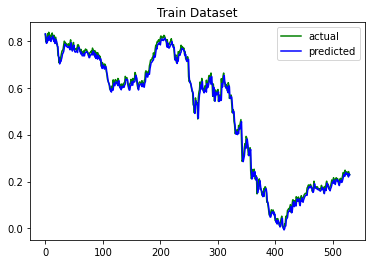

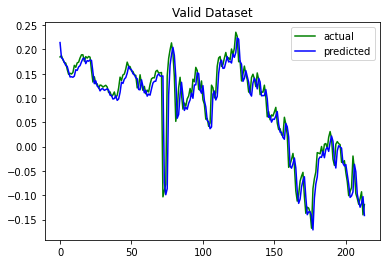

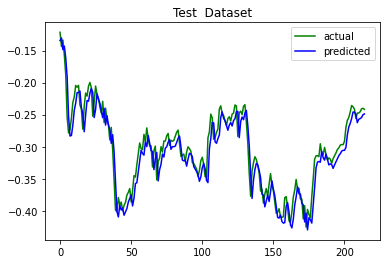

In [ ]:
result= resultados(
               model = "narx2",
               ts=('^BVSP'), 
               period = "3d",
               interval = "1m",
               epochs=1000, 
               patience = 25,
               delay=0,
              )

[*********************100%***********************]  1 of 1 completed
Importação da série temporal concluida
Tau = 1
Dy = 198
Dy2 = 3
Data Train, Data Validation and Data Test
Normalização concluida
Divisão dos dados em Treino, validação e teste
Load Model
Rolling Window
Train Model
Epoch 1/1000
45/45 [==============================] - 7s 122ms/step - loss: 1.2093 - val_loss: 0.3190
Epoch 2/1000
45/45 [==============================] - 4s 98ms/step - loss: 0.0570 - val_loss: 0.2108
Epoch 3/1000
45/45 [==============================] - 4s 98ms/step - loss: 0.0533 - val_loss: 0.2383
Epoch 4/1000
45/45 [==============================] - 4s 97ms/step - loss: 0.0517 - val_loss: 0.1855
Epoch 5/1000
45/45 [==============================] - 4s 97ms/step - loss: 0.0498 - val_loss: 0.2077
Epoch 6/1000
45/45 [==============================] - 4s 98ms/step - loss: 0.0467 - val_loss: 0.1957
Epoch 7/1000
45/45 [==============================] - 4s 97ms/step - loss: 0.0438 - val_loss: 0.1552
Epoch 8/1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars


MSE: (Mean Squared Error) 5.154688865775863e-05
MAE: Mean Absolute Error 0.0050559392246129434
RMSE: (Root Mean Square Error): 0.007179616191535494
MAPE (Mean Absolute Percentage Error): 0.059607268695482114
POCID (Prediction of Change in Direction): 0.6047794117647058
R2 (Coeficiente de Determinação): 0.9837611486850102
Theil’s U1 : 0.02284642523423383
Theil’s U2 : 1.0003012626373757
Forecasting Test Data
MSE: (Mean Squared Error) 7.095075692492097e-05
MAE: Mean Absolute Error 0.005762762286068563
RMSE: (Root Mean Square Error): 0.00842322722743017
MAPE (Mean Absolute Percentage Error): 0.023893499137469066
POCID (Prediction of Change in Direction): 0.5853211009174312
R2 (Coeficiente de Determinação): 0.9972516054434359
Theil’s U1 : 0.010772495321655867
Theil’s U2 : 1.069495126905275
Resultados


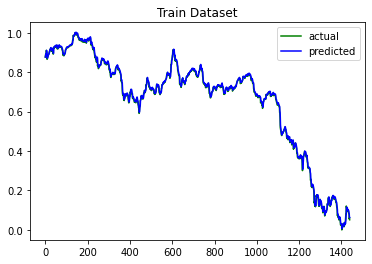

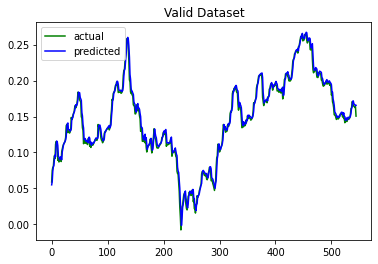

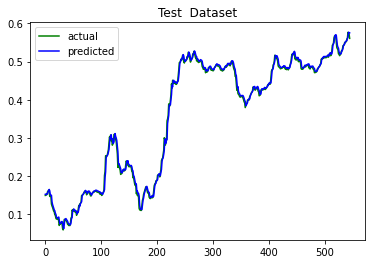

In [ ]:
result= resultados(
               model = "narx2",
               ts=('BNB-USD'), 
               period = "3d",
               interval = "1m",
               epochs=1000, 
               patience = 25,
               delay=0,
              )

In [ ]:
-%tensorboard --logdir $logdir_run

[*********************100%***********************]  1 of 1 completed
Importação da série temporal concluida
Tau = 1
Dy = 143
Dy2 = 5
Data Train, Data Validation and Data Test
Normalização concluida
Divisão dos dados em Treino, validação e teste
Load Model
Rolling Window
Train Model
Epoch 1/1000
43/43 [==============================] - 6s 84ms/step - loss: 0.5324 - val_loss: 0.0289
Epoch 2/1000
43/43 [==============================] - 2s 45ms/step - loss: 0.0226 - val_loss: 0.0466
Epoch 3/1000
43/43 [==============================] - 2s 42ms/step - loss: 0.0221 - val_loss: 0.0530
Epoch 4/1000
43/43 [==============================] - 2s 44ms/step - loss: 0.0244 - val_loss: 0.0352
Epoch 5/1000
43/43 [==============================] - 2s 43ms/step - loss: 0.0218 - val_loss: 0.1025
Epoch 6/1000
43/43 [==============================] - 2s 44ms/step - loss: 0.0220 - val_loss: 0.0561
Epoch 7/1000
43/43 [==============================] - 2s 43ms/step - loss: 0.0218 - val_loss: 0.0507
Epoch 8/10

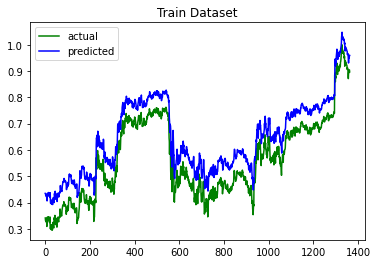

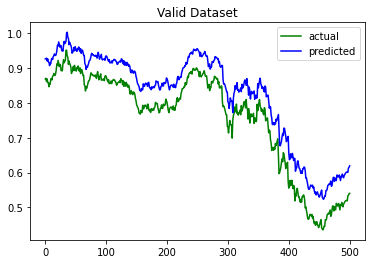

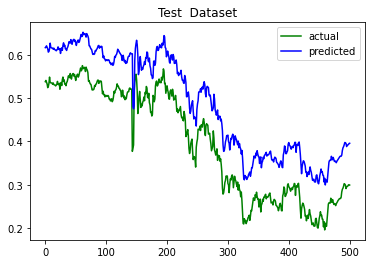

In [ ]:
result= resultados(
               model = "narx2",
               ts=('^BVSP'), 
               period = "7d",
               interval = "1m",
               epochs=1000, 
               patience = 25,
               delay=0,
              )

[*********************100%***********************]  1 of 1 completed
Importação da série temporal concluida
Tau = 1
Dy = 143
Dy2 = 5
Data Train, Data Validation and Data Test
Normalização concluida
Divisão dos dados em Treino, validação e teste
Load Model
Rolling Window
Train Model
Epoch 1/1000
43/43 [==============================] - 4s 65ms/step - loss: 2.7429 - val_loss: 0.0332
Epoch 2/1000
43/43 [==============================] - 2s 44ms/step - loss: 0.0296 - val_loss: 0.0633
Epoch 3/1000
43/43 [==============================] - 2s 42ms/step - loss: 0.0236 - val_loss: 0.0683
Epoch 4/1000
43/43 [==============================] - 2s 45ms/step - loss: 0.0232 - val_loss: 0.0588
Epoch 5/1000
43/43 [==============================] - 2s 43ms/step - loss: 0.0229 - val_loss: 0.0538
Epoch 6/1000
43/43 [==============================] - 2s 43ms/step - loss: 0.0222 - val_loss: 0.0507
Epoch 7/1000
43/43 [==============================] - 2s 45ms/step - loss: 0.0218 - val_loss: 0.0636
Epoch 8/10

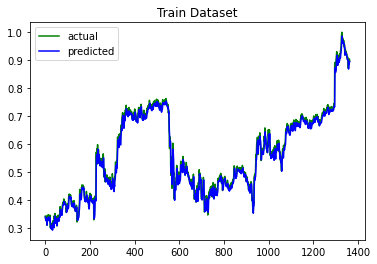

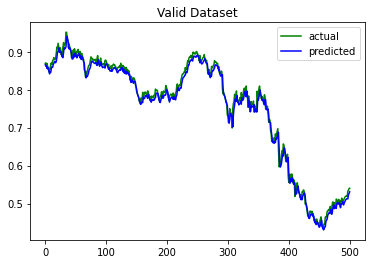

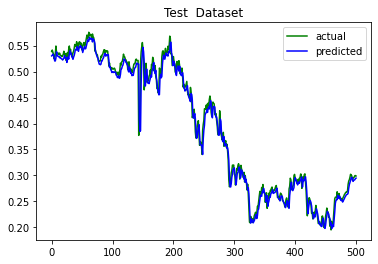

In [ ]:
result= resultados(
               model = "narx2",
               ts=('^BVSP'), 
               period = "7d",
               interval = "1m",
               epochs=1000, 
               patience = 25,
               delay=0,
              )

[*********************100%***********************]  1 of 1 completed
Importação da série temporal concluida
Tau = 1
Dy = 200
Dy2 = 4
Data Train, Data Validation and Data Test
Normalização concluida
Divisão dos dados em Treino, validação e teste
Load Model
Rolling Window
Train Model
Epoch 1/100
128/128 [==============================] - 13s 97ms/step - loss: 2.0589 - val_loss: 0.1829
Epoch 2/100
128/128 [==============================] - 12s 95ms/step - loss: 0.0616 - val_loss: 0.1492
Epoch 3/100
128/128 [==============================] - 12s 97ms/step - loss: 0.0478 - val_loss: 0.0885
Epoch 4/100
128/128 [==============================] - 12s 95ms/step - loss: 0.0154 - val_loss: 0.0011
Epoch 5/100
128/128 [==============================] - 12s 95ms/step - loss: 6.6428e-04 - val_loss: 2.5224e-04
Epoch 6/100
128/128 [==============================] - 13s 104ms/step - loss: 2.9361e-04 - val_loss: 2.7507e-04
Epoch 7/100
128/128 [==============================] - 17s 135ms/step - loss: 2.22

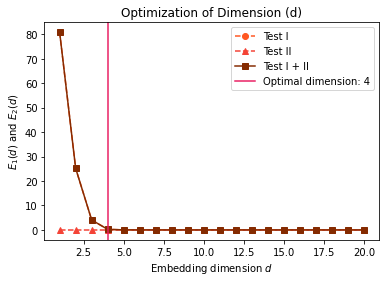

In [ ]:
+result= resultados(
               model = "narx2",
               ts=('^BVSP'), 
               period = "max",
               interval = "1d",
               epochs=100, 
               patience = 25,
               delay=0,
               )

[*********************100%***********************]  1 of 1 completed
Importação da série temporal concluida
Tau = 1
Dy = 100
Dy2 = 4
Data Train, Data Validation and Data Test
Normalização concluida
Divisão dos dados em Treino, validação e teste
Load Model
Rolling Window
Train Model
Epoch 1/1000
131/131 [==============================] - 4s 26ms/step - loss: 0.4527 - val_loss: 0.1319
Epoch 2/1000
131/131 [==============================] - 3s 25ms/step - loss: 0.0263 - val_loss: 0.0028
Epoch 3/1000
131/131 [==============================] - 3s 25ms/step - loss: 4.6893e-04 - val_loss: 1.4679e-04
Epoch 4/1000
131/131 [==============================] - 3s 24ms/step - loss: 7.8944e-05 - val_loss: 1.4671e-04
Epoch 5/1000
131/131 [==============================] - 3s 24ms/step - loss: 7.9743e-05 - val_loss: 1.3532e-04
Epoch 6/1000
131/131 [==============================] - 3s 25ms/step - loss: 7.5022e-05 - val_loss: 1.3924e-04
Epoch 7/1000
131/131 [==============================] - 3s 25ms/ste

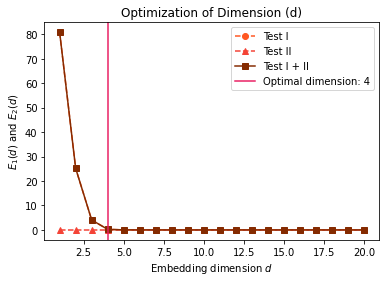

In [ ]:
result= resultados(
               model = "narx2",
               ts=('^BVSP'), 
               period = "max",
               interval = "1d",
               epochs=1000, 
               patience = 25,
               delay=0,
               )

##LSTM

In [ ]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

def lstm(Time_Lag):
  # define model
  lstm = Sequential()
  lstm.add(LSTM(Time_Lag, activation='sigmoid', input_shape=(Time_Lag, 1)))
  lstm.add(Dense(2*np.sqrt(3*Time_Lag), activation='sigmoid'))
  lstm.add(Dense(1))
  lstm.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.01, decay=1e-6),
              loss = "mse")
  return lstm

###Série Diferenciada

[*********************100%***********************]  1 of 1 completed
Importação da série temporal concluida
Tau = 5
Dy = 5
Dy2 = 5
Data Train, Data Validation and Data Test
Normalização concluida
Divisão dos dados em Treino, validação e teste
Load Model
Rolling Window
Train Model
Epoch 1/100
46/46 [==============================] - 2s 11ms/step - loss: 0.2662 - val_loss: 0.0051
Epoch 2/100
46/46 [==============================] - 0s 5ms/step - loss: 0.0011 - val_loss: 6.1613e-04
Epoch 3/100
46/46 [==============================] - 0s 7ms/step - loss: 4.7560e-04 - val_loss: 5.2635e-04
Epoch 4/100
46/46 [==============================] - 0s 5ms/step - loss: 4.6630e-04 - val_loss: 5.1561e-04
Epoch 5/100
46/46 [==============================] - 0s 6ms/step - loss: 4.6465e-04 - val_loss: 5.1985e-04
Epoch 6/100
46/46 [==============================] - 0s 6ms/step - loss: 4.6676e-04 - val_loss: 5.1656e-04
Epoch 7/100
46/46 [==============================] - 0s 5ms/step - loss: 4.6504e-04 - va

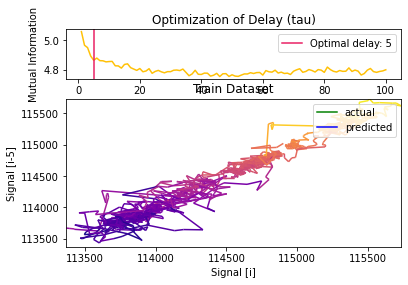

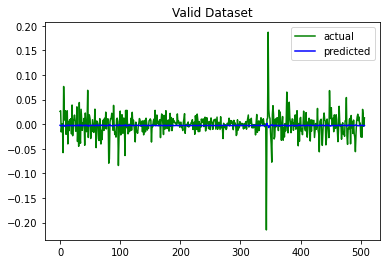

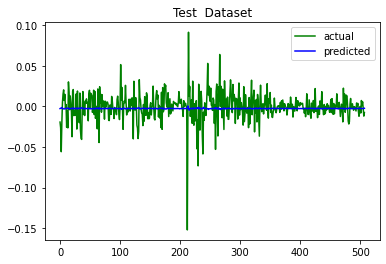

In [ ]:
result= resultados(
               model = "lstm",
               ts=('^BVSP'), 
               period = "7d",
               interval = "1m",
               epochs=100, 
               patience = 10,
               delay=0,
               diff=True
              )

###Série não Diferenciada

[*********************100%***********************]  1 of 1 completed
Importação da série temporal concluida
Tau = 1
Dy = 198
Dy2 = 6
Data Train, Data Validation and Data Test
Normalização concluida
Divisão dos dados em Treino, validação e teste
Load Model
Rolling Window
Train Model
Epoch 1/100
41/41 [==============================] - 25s 580ms/step - loss: 0.2634 - val_loss: 0.1514
Epoch 2/100
41/41 [==============================] - 24s 576ms/step - loss: 0.0575 - val_loss: 0.0940
Epoch 3/100
41/41 [==============================] - 24s 580ms/step - loss: 0.0520 - val_loss: 0.0796
Epoch 4/100
41/41 [==============================] - 24s 576ms/step - loss: 0.0423 - val_loss: 0.0576
Epoch 5/100
41/41 [==============================] - 24s 578ms/step - loss: 0.0152 - val_loss: 0.0018
Epoch 6/100
41/41 [==============================] - 24s 581ms/step - loss: 0.0010 - val_loss: 0.0013
Epoch 7/100
41/41 [==============================] - 24s 575ms/step - loss: 7.6764e-04 - val_loss: 0.0015

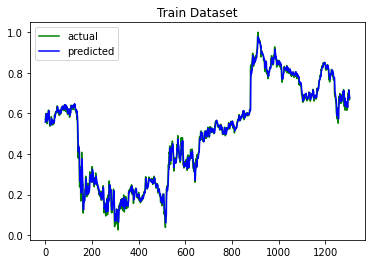

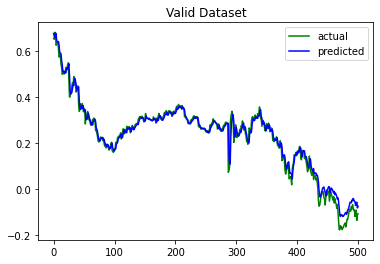

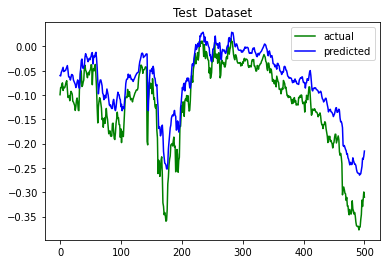

In [ ]:
result= resultados(
               model = "lstm",
               ts=('^BVSP'), 
               period = "7d",
               interval = "1m",
               epochs=100, 
               patience = 10,
               delay=0,
               diff=False
              )

In [ ]:
result= resultados(
               model = "lstm",
               ts=('BTC-USD'), 
               period = "7d",
               interval = "1m",
               epochs=100, 
               patience = 10,
               delay=0,
               diff=False
              )

[*********************100%***********************]  1 of 1 completed
Importação da série temporal concluida
Tau = 1
Dy = 929
Dy2 = 5
Data Train, Data Validation and Data Test
Normalização concluida
Divisão dos dados em Treino, validação e teste
Load Model
Rolling Window
Train Model
Epoch 1/100
131/131 [==============================] - 368s 3s/step - loss: 0.9686 - val_loss: 0.3621
Epoch 2/100
131/131 [==============================] - 370s 3s/step - loss: 0.0955 - val_loss: 0.2913
Epoch 3/100
131/131 [==============================] - 346s 3s/step - loss: 0.0956 - val_loss: 0.2715
Epoch 4/100
131/131 [==============================] - 339s 3s/step - loss: 0.0983 - val_loss: 0.2990
Epoch 5/100
131/131 [==============================] - 344s 3s/step - loss: 0.0961 - val_loss: 0.2842
Epoch 6/100
131/131 [==============================] - 338s 3s/step - loss: 0.0980 - val_loss: 0.2289
Epoch 7/100
131/131 [==============================] - 344s 3s/step - loss: 0.0976 - val_loss: 0.2797
Epo

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars


MSE: (Mean Squared Error) 0.2743679422809978
MAE: Mean Absolute Error 0.521912672525595
RMSE: (Root Mean Square Error): 0.5238014340196081
MAPE (Mean Absolute Percentage Error): 17.90157675956197
POCID (Prediction of Change in Direction): 0.01650943396226415
R2 (Coeficiente de Determinação): -137.91300415192555
Theil’s U1 : 0.7658649159104881
Theil’s U2 : 431.9824137461719
Forecasting Test Data
MSE: (Mean Squared Error) 0.6726084676746724
MAE: Mean Absolute Error 0.8148498304178635
RMSE: (Root Mean Square Error): 0.8201271045848152
MAPE (Mean Absolute Percentage Error): 4.490712123598495
POCID (Prediction of Change in Direction): 0.002357100766057749
R2 (Coeficiente de Determinação): -76.95445476233496
Theil’s U1 : 0.9835901112448309
Theil’s U2 : 162.7220803998797
Resultados


[*********************100%***********************]  1 of 1 completed
Importação da série temporal concluida
Tau = 1
Dy = 39
Dy2 = 4
Data Train, Data Validation and Data Test
Normalização concluida
1
Divisão dos dados em Treino, validação e teste
Load Model
Rolling Window
Train Model
Epoch 1/100
133/133 [==============================] - 17s 118ms/step - loss: 0.0773 - val_loss: 0.0101
Epoch 2/100
133/133 [==============================] - 16s 119ms/step - loss: 8.1363e-04 - val_loss: 4.9042e-04
Epoch 3/100
133/133 [==============================] - 16s 120ms/step - loss: 2.1648e-04 - val_loss: 2.9316e-04
Epoch 4/100
133/133 [==============================] - 16s 119ms/step - loss: 1.2560e-04 - val_loss: 1.6470e-04
Epoch 5/100
133/133 [==============================] - 17s 125ms/step - loss: 7.0798e-05 - val_loss: 2.0524e-04
Epoch 6/100
133/133 [==============================] - 16s 122ms/step - loss: 5.3568e-05 - val_loss: 1.3269e-04
Epoch 7/100
133/133 [==============================]

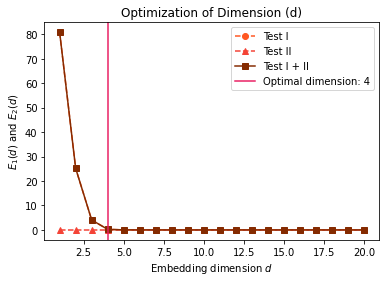

In [ ]:
result= resultados(
               model = "lstm",
               ts=('^BVSP'), 
               period = "max",
               interval = "1d",
               epochs=100, 
               patience = 10,
               delay=1,
              )

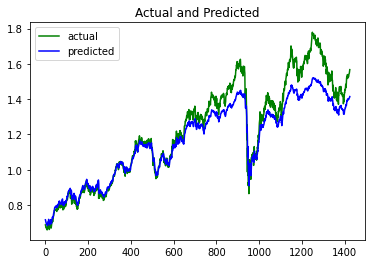

In [ ]:
plt.plot(np.array(result[0]), 'g', label='actual')
plt.plot(np.array(result[1]), 'b', label='predicted')
plt.title('Actual and Predicted')
plt.legend()
plt.show()

In [ ]:
result= resultados(
               model = "lstm",
               ts=('^BVSP'), 
               period = "max",
               interval = "1d",
               epochs=100, 
               patience = 10,
               delay=0,
              )

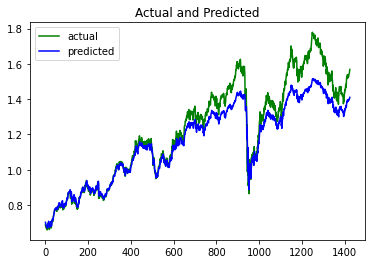

In [ ]:
plt.plot(np.array(result[0]), 'g', label='actual')
plt.plot(np.array(result[1]), 'b', label='predicted')
plt.title('Actual and Predicted')
plt.legend()
plt.show()

##Narx


In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#de < dy <= tau.de
def narx(Time_Lag=50):
    class Narx(keras.Model):
        def __init__(self):
            super(Narx, self).__init__(name='narx')
            self.dense = keras.layers.Dense(round(Time_Lag), input_shape=(None, Time_Lag+1), activation=keras.activations.sigmoid)
            self.dense = keras.layers.Dense(round(2*np.sqrt(3*Time_Lag)), activation=keras.activations.linear)
            self.outputLayer = keras.layers.Dense(1, activation=keras.activations.linear)

        def call(self, inputs, training = True):
            if (training):
                x = self.dense(inputs)
                return self.outputLayer(x)
            else: 
                x = self.dense(inputs)
                return self.outputLayer(x)
    narx = Narx()
    narx.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), 
                 loss='mse')
    return narx

###Baixa Frequencia

In [ ]:
result= resultados(
               model = "narx",
               ts=('BTC-USD'), 
               period = "max",
               interval = "1d",
               epochs=1000, 
               patience = 25,
               delay=0,
               )

[*********************100%***********************]  1 of 1 completed
Importação da série temporal concluida
Tau = 1
Dy = 39
Dy2 = 4
Data Train, Data Validation and Data Test
Normalização concluida
1
Divisão dos dados em Treino, validação e teste
Load Model
Rolling Window
Train Model
Epoch 1/1000
50/50 [==============================] - 1s 12ms/step - loss: 0.0182 - val_loss: 0.0026
Epoch 2/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0014 - val_loss: 0.0039
Epoch 3/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 4/1000
50/50 [==============================] - 0s 8ms/step - loss: 8.9926e-04 - val_loss: 0.0036
Epoch 5/1000
50/50 [==============================] - 0s 9ms/step - loss: 9.0625e-04 - val_loss: 0.0034
Epoch 6/1000
50/50 [==============================] - 0s 9ms/step - loss: 6.3514e-04 - val_loss: 9.3829e-04
Epoch 7/1000
50/50 [==============================] - 1s 10ms/step - loss: 8.9816e-04 - val_loss: 7

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars


17/17 [==============================] - 0s 2ms/step
MSE: (Mean Squared Error) 0.026371396665546352
MAE: Mean Absolute Error 0.1330903902789899
RMSE: (Root Mean Square Error): 0.16239272356095993
MAPE (Mean Absolute Percentage Error): 0.06605653560255982
POCID (Prediction of Change in Direction): 0.5037037037037037
R2 (Coeficiente de Determinação): 0.9614641828913277
Theil’s U1 : 0.03837573518082156
Theil’s U2 : 1.9754847086903444
Resultados


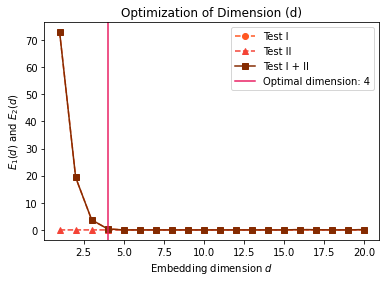

In [ ]:
result= resultados(
               model = "narx",
               ts=('BTC-USD'), 
               period = "max",
               interval = "1d",
               epochs=1000, 
               patience = 50,
               delay=0,
               )

[*********************100%***********************]  1 of 1 completed
Importação da série temporal concluida
Tau = 1
Dy = 39
Dy2 = 4
Data Train, Data Validation and Data Test
Normalização concluida
1
Divisão dos dados em Treino, validação e teste
Load Model
Rolling Window
Train Model
Epoch 1/1000
50/50 [==============================] - 1s 14ms/step - loss: 0.0303 - val_loss: 0.0112
Epoch 2/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0024 - val_loss: 0.0052
Epoch 3/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0014 - val_loss: 0.0017
Epoch 4/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.0011 - val_loss: 0.0044
Epoch 5/1000
50/50 [==============================] - 0s 8ms/step - loss: 7.9342e-04 - val_loss: 0.0011
Epoch 6/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.0023 - val_loss: 0.0045
Epoch 7/1000
50/50 [==============================] - 0s 8ms/step - loss: 6.8760e-04 - val_loss: 0.0011
Epoch 8

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars


17/17 [==============================] - 0s 5ms/step
MSE: (Mean Squared Error) 0.0006888549943966721
MAE: Mean Absolute Error 0.02048406582329773
RMSE: (Root Mean Square Error): 0.02624604721470782
MAPE (Mean Absolute Percentage Error): 0.04875988252271765
POCID (Prediction of Change in Direction): 0.4666666666666667
R2 (Coeficiente de Determinação): 0.9365787502939915
Theil’s U1 : 0.029153715136372056
Theil’s U2 : 1.4898218478697185
Forecasting Test Data
17/17 [==============================] - 0s 2ms/step
MSE: (Mean Squared Error) 0.013662253977641675
MAE: Mean Absolute Error 0.08591275681146918
RMSE: (Root Mean Square Error): 0.11688564487413189
MAPE (Mean Absolute Percentage Error): 0.04272756861966166
POCID (Prediction of Change in Direction): 0.48703703703703705
R2 (Coeficiente de Determinação): 0.9800357920733261
Theil’s U1 : 0.0263486740674625
Theil’s U2 : 1.3556672576782893
Resultados


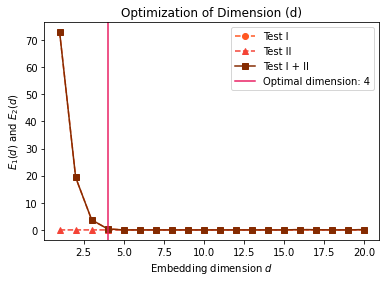

In [ ]:
result= resultados(
               model = "narx",
               ts=('BTC-USD'), 
               period = "max",
               interval = "1d",
               epochs=1000, 
               patience = 50,
               delay=0,
               )

[*********************100%***********************]  1 of 1 completed
Importação da série temporal concluida
Tau = 1
Dy = 39
Dy2 = 4
Data Train, Data Validation and Data Test
Normalização concluida
1
Divisão dos dados em Treino, validação e teste
Load Model
Rolling Window
Train Model
Epoch 1/1000
50/50 [==============================] - 1s 8ms/step - loss: 0.0209 - val_loss: 0.0090
Epoch 2/1000
50/50 [==============================] - 0s 5ms/step - loss: 0.0011 - val_loss: 0.0017
Epoch 3/1000
50/50 [==============================] - 0s 5ms/step - loss: 6.3020e-04 - val_loss: 6.8172e-04
Epoch 4/1000
50/50 [==============================] - 0s 6ms/step - loss: 6.3072e-04 - val_loss: 0.0016
Epoch 5/1000
50/50 [==============================] - 0s 5ms/step - loss: 6.4422e-04 - val_loss: 9.8204e-04
Epoch 6/1000
50/50 [==============================] - 0s 6ms/step - loss: 3.9582e-04 - val_loss: 4.7304e-04
Epoch 7/1000
50/50 [==============================] - 0s 6ms/step - loss: 4.7967e-04 - v

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars


17/17 [==============================] - 0s 2ms/step
MSE: (Mean Squared Error) 0.00713245773923428
MAE: Mean Absolute Error 0.05834570929880309
RMSE: (Root Mean Square Error): 0.08445387936166272
MAPE (Mean Absolute Percentage Error): 0.02839001053846514
POCID (Prediction of Change in Direction): 0.4759259259259259
R2 (Coeficiente de Determinação): 0.9895775362998132
Theil’s U1 : 0.019365546387151152
Theil’s U2 : 1.0029395943956148
Resultados


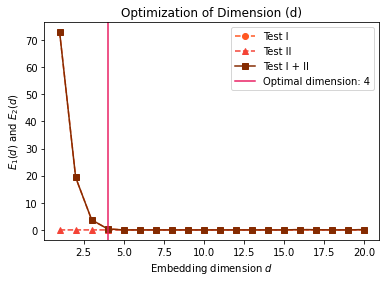

In [ ]:
result= resultados(
               model = "narx",
               ts=('BTC-USD'), 
               period = "max",
               interval = "1d",
               epochs=1000, 
               patience = 50,
               delay=1,
               )

[*********************100%***********************]  1 of 1 completed
Importação da série temporal concluida
Tau = 1
Dy = 39
Dy2 = 4
Data Train, Data Validation and Data Test
Normalização concluida
1
Divisão dos dados em Treino, validação e teste
Load Model
Rolling Window
Train Model
Epoch 1/1000
50/50 [==============================] - 1s 7ms/step - loss: 0.0188 - val_loss: 0.0035
Epoch 2/1000
50/50 [==============================] - 0s 6ms/step - loss: 0.0018 - val_loss: 0.0020
Epoch 3/1000
50/50 [==============================] - 0s 5ms/step - loss: 0.0011 - val_loss: 0.0015
Epoch 4/1000
50/50 [==============================] - 0s 5ms/step - loss: 0.0015 - val_loss: 7.0397e-04
Epoch 5/1000
50/50 [==============================] - 0s 5ms/step - loss: 6.1831e-04 - val_loss: 0.0014
Epoch 6/1000
50/50 [==============================] - 0s 5ms/step - loss: 3.9618e-04 - val_loss: 0.0016
Epoch 7/1000
50/50 [==============================] - 0s 5ms/step - loss: 7.3394e-04 - val_loss: 4.7216e

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars


17/17 [==============================] - 0s 2ms/step
MSE: (Mean Squared Error) 0.007889992392678803
MAE: Mean Absolute Error 0.06407824952107126
RMSE: (Root Mean Square Error): 0.08882562914316341
MAPE (Mean Absolute Percentage Error): 0.03145820795506887
POCID (Prediction of Change in Direction): 0.4981481481481482
R2 (Coeficiente de Determinação): 0.9884705692100842
Theil’s U1 : 0.02048285441712037
Theil’s U2 : 1.0765471052719124
Resultados


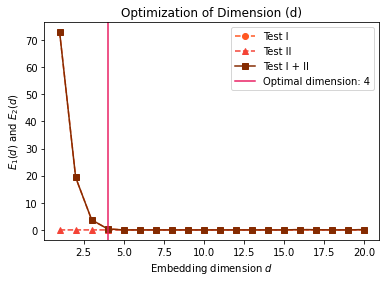

In [ ]:
result= resultados(
               model = "narx",
               ts=('BTC-USD'), 
               period = "max",
               interval = "1d",
               epochs=1000, 
               patience = 20,
               delay=1,
               )

[*********************100%***********************]  1 of 1 completed
Janela Temporal 15 , 294 e 794


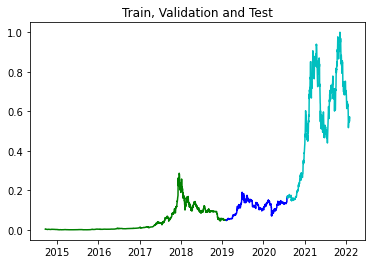

Epoch 1/1000
51/51 [==============================] - 1s 5ms/step - loss: 2.1420e-04 - val_loss: 3.9130e-05
Epoch 2/1000
51/51 [==============================] - 0s 3ms/step - loss: 3.3284e-05 - val_loss: 2.2300e-05
Epoch 3/1000
51/51 [==============================] - 0s 3ms/step - loss: 2.4548e-05 - val_loss: 1.0697e-04
Epoch 4/1000
51/51 [==============================] - 0s 3ms/step - loss: 3.8579e-05 - val_loss: 1.2062e-05
Epoch 5/1000
51/51 [==============================] - 0s 3ms/step - loss: 1.4660e-05 - val_loss: 2.4462e-05
Epoch 6/1000
51/51 [==============================] - 0s 3ms/step - loss: 1.7403e-05 - val_loss: 8.3200e-06
Epoch 7/1000
51/51 [==============================] - 0s 3ms/step - loss: 2.9741e-05 - val_loss: 6.9291e-05
Epoch 8/1000
51/51 [==============================] - 0s 3ms/step - loss: 2.2331e-05 - val_loss: 9.1912e-06
Epoch 9/1000
51/51 [==============================] - 0s 3ms/step - loss: 1.8396e-05 - val_loss: 2.0915e-05
Epoch 10/1000
51/51 [=======

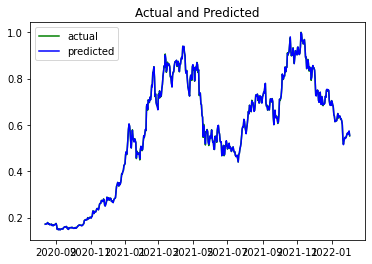

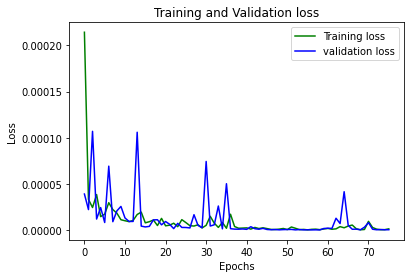

In [ ]:
result= resultados(
               model = "narx",
               ts=('BTC-USD'), 
               period = "max",
               interval = "1d",
               epochs=1000, 
               patience = 20,
               delay=1,
               )

[*********************100%***********************]  1 of 1 completed
Janela Temporal 2 , 294 e 794


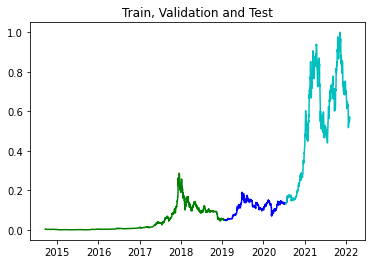

Epoch 1/1000
50/50 [==============================] - 1s 5ms/step - loss: 0.0015 - val_loss: 1.3064e-04
Epoch 2/1000
50/50 [==============================] - 0s 3ms/step - loss: 1.1444e-04 - val_loss: 9.8618e-05
Epoch 3/1000
50/50 [==============================] - 0s 3ms/step - loss: 1.0072e-04 - val_loss: 8.9468e-05
Epoch 4/1000
50/50 [==============================] - 0s 3ms/step - loss: 6.7073e-05 - val_loss: 1.9423e-04
Epoch 5/1000
50/50 [==============================] - 0s 3ms/step - loss: 1.1079e-04 - val_loss: 1.7282e-04
Epoch 6/1000
50/50 [==============================] - 0s 3ms/step - loss: 1.0492e-04 - val_loss: 7.8442e-05
Epoch 7/1000
50/50 [==============================] - 0s 3ms/step - loss: 5.8982e-05 - val_loss: 7.0229e-05
Epoch 8/1000
50/50 [==============================] - 0s 3ms/step - loss: 5.6742e-05 - val_loss: 5.3909e-05
Epoch 9/1000
50/50 [==============================] - 0s 3ms/step - loss: 5.1083e-05 - val_loss: 4.5949e-05
Epoch 10/1000
50/50 [===========

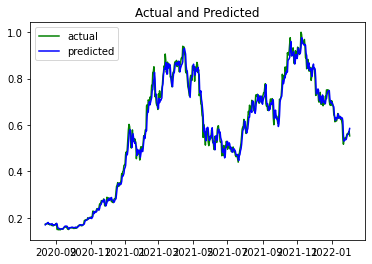

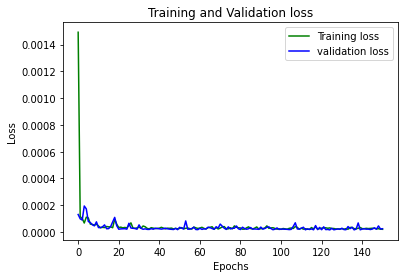

In [ ]:
result= resultados(
               model = "narx",
               ts=('BTC-USD'), 
               period = "max",
               interval = "1d",
               epochs=1000, 
               patience = 50,
               delay=0,
               )

[*********************100%***********************]  1 of 1 completed
Janela Temporal 15 , 294 e 794


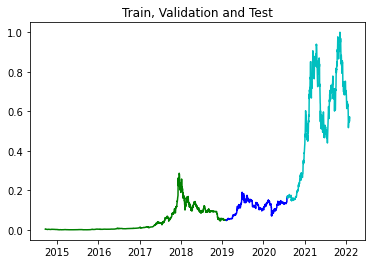

Epoch 1/1000
51/51 [==============================] - 1s 5ms/step - loss: 6.0679e-04 - val_loss: 1.2882e-04
Epoch 2/1000
51/51 [==============================] - 0s 3ms/step - loss: 8.4206e-05 - val_loss: 6.1964e-05
Epoch 3/1000
51/51 [==============================] - 0s 3ms/step - loss: 4.4041e-05 - val_loss: 6.7423e-05
Epoch 4/1000
51/51 [==============================] - 0s 3ms/step - loss: 3.0710e-05 - val_loss: 3.7591e-05
Epoch 5/1000
51/51 [==============================] - 0s 3ms/step - loss: 3.2319e-05 - val_loss: 1.6156e-05
Epoch 6/1000
51/51 [==============================] - 0s 3ms/step - loss: 2.0294e-05 - val_loss: 2.0447e-04
Epoch 7/1000
51/51 [==============================] - 0s 3ms/step - loss: 6.6862e-05 - val_loss: 2.1965e-05
Epoch 8/1000
51/51 [==============================] - 0s 3ms/step - loss: 1.5537e-05 - val_loss: 9.9866e-06
Epoch 9/1000
51/51 [==============================] - 0s 3ms/step - loss: 1.5339e-05 - val_loss: 1.0174e-05
Epoch 10/1000
51/51 [=======

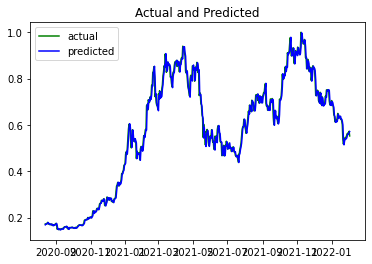

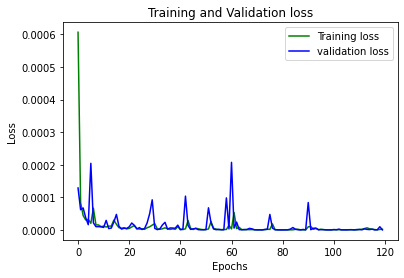

In [ ]:
result= resultados(
               model = "narx",
               ts=('BTC-USD'), 
               period = "max",
               interval = "1d",
               epochs=1000, 
               patience = 20,
               delay=1,
               )

###Alta Frequencia

[*********************100%***********************]  1 of 1 completed
Janela Temporal 2 , 403 e 675
Epoch 1/500
129/129 [==============================] - 1s 6ms/step - loss: 0.0049 - val_loss: 0.0015
Epoch 2/500
129/129 [==============================] - 1s 5ms/step - loss: 6.3992e-04 - val_loss: 6.4441e-04
Epoch 3/500
129/129 [==============================] - 1s 5ms/step - loss: 3.7930e-04 - val_loss: 3.8984e-04
Epoch 4/500
129/129 [==============================] - 1s 5ms/step - loss: 2.7095e-04 - val_loss: 2.9835e-04
Epoch 5/500
129/129 [==============================] - 1s 5ms/step - loss: 2.2013e-04 - val_loss: 3.3419e-04
Epoch 6/500
129/129 [==============================] - 1s 5ms/step - loss: 2.0338e-04 - val_loss: 2.1167e-04
Epoch 7/500
129/129 [==============================] - 1s 5ms/step - loss: 1.5964e-04 - val_loss: 1.9210e-04
Epoch 8/500
129/129 [==============================] - 1s 5ms/step - loss: 1.6153e-04 - val_loss: 1.6837e-04
Epoch 9/500
129/129 [================

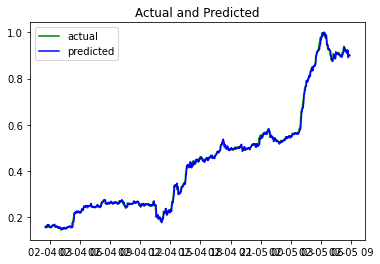

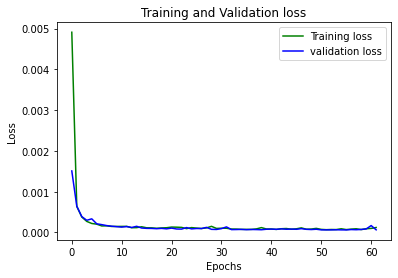

In [ ]:
result=resultados(
            model = "narx",
            ts=('BNB-USD'), 
            period = "7d",
            interval = "1m",
            epochs=500, 
            patience = 10,
            delay=0,
            )

[*********************100%***********************]  1 of 1 completed
Janela Temporal 2 , 405 e 676
Epoch 1/1000
129/129 [==============================] - 1s 5ms/step - loss: 0.0820 - val_loss: 9.7019e-04
Epoch 2/1000
129/129 [==============================] - 1s 5ms/step - loss: 7.2848e-04 - val_loss: 9.7820e-04
Epoch 3/1000
129/129 [==============================] - 1s 4ms/step - loss: 5.0392e-04 - val_loss: 6.3095e-04
Epoch 4/1000
129/129 [==============================] - 1s 4ms/step - loss: 3.7300e-04 - val_loss: 5.0012e-04
Epoch 5/1000
129/129 [==============================] - 1s 5ms/step - loss: 3.1184e-04 - val_loss: 4.0173e-04
Epoch 6/1000
129/129 [==============================] - 1s 5ms/step - loss: 2.7453e-04 - val_loss: 3.2871e-04
Epoch 7/1000
129/129 [==============================] - 1s 5ms/step - loss: 2.3808e-04 - val_loss: 2.7423e-04
Epoch 8/1000
129/129 [==============================] - 1s 5ms/step - loss: 1.9189e-04 - val_loss: 2.4331e-04
Epoch 9/1000
129/129 [===

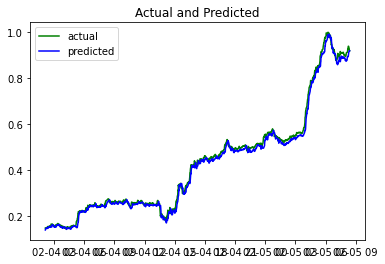

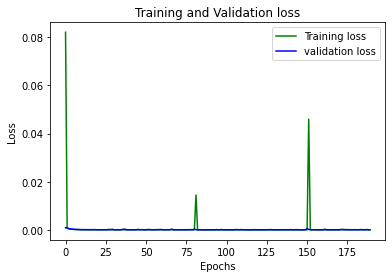

In [ ]:
result=resultados(
            model = "narx",
            ts=('BNB-USD'), 
            period = "7d",
            interval = "1m",
            epochs=1000, 
            patience = 100,
            delay=1,
            )

[*********************100%***********************]  1 of 1 completed
Janela Temporal 2 , 637 e 1094
Epoch 1/500
147/147 [==============================] - 1s 6ms/step - loss: 0.1405 - val_loss: 9.6070e-04
Epoch 2/500
147/147 [==============================] - 1s 5ms/step - loss: 0.0011 - val_loss: 7.4556e-04
Epoch 3/500
147/147 [==============================] - 1s 5ms/step - loss: 7.5356e-04 - val_loss: 5.7608e-04
Epoch 4/500
147/147 [==============================] - 1s 5ms/step - loss: 6.2039e-04 - val_loss: 6.2474e-04
Epoch 5/500
147/147 [==============================] - 1s 5ms/step - loss: 4.9772e-04 - val_loss: 4.5127e-04
Epoch 6/500
147/147 [==============================] - 1s 5ms/step - loss: 4.4165e-04 - val_loss: 4.0531e-04
Epoch 7/500
147/147 [==============================] - 1s 5ms/step - loss: 4.1680e-04 - val_loss: 3.8488e-04
Epoch 8/500
147/147 [==============================] - 1s 6ms/step - loss: 3.5641e-04 - val_loss: 3.4909e-04
Epoch 9/500
147/147 [===============

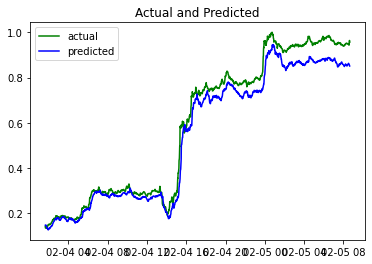

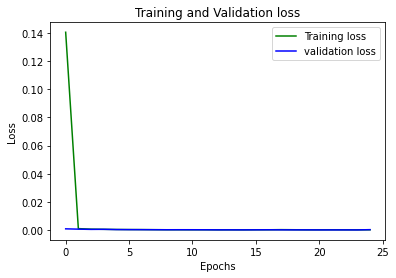

In [ ]:
result=resultados(
            model = "narx",
            ts=('BTC-USD'), 
            period = "7d",
            interval = "1m",
            epochs=500, 
            patience = 10,
            delay=0,
            )

[*********************100%***********************]  1 of 1 completed
Janela Temporal 2 , 404 e 675
Epoch 1/500
129/129 [==============================] - 1s 6ms/step - loss: 0.0571 - val_loss: 6.7408e-04
Epoch 2/500
129/129 [==============================] - 1s 5ms/step - loss: 4.1148e-04 - val_loss: 4.6650e-04
Epoch 3/500
129/129 [==============================] - 1s 5ms/step - loss: 3.0039e-04 - val_loss: 3.4205e-04
Epoch 4/500
129/129 [==============================] - 1s 5ms/step - loss: 2.5465e-04 - val_loss: 3.4218e-04
Epoch 5/500
129/129 [==============================] - 1s 4ms/step - loss: 2.4350e-04 - val_loss: 2.4804e-04
Epoch 6/500
129/129 [==============================] - 1s 5ms/step - loss: 2.0595e-04 - val_loss: 2.2828e-04
Epoch 7/500
129/129 [==============================] - 1s 5ms/step - loss: 1.8298e-04 - val_loss: 2.1547e-04
Epoch 8/500
129/129 [==============================] - 1s 4ms/step - loss: 1.7433e-04 - val_loss: 2.0077e-04
Epoch 9/500
129/129 [============

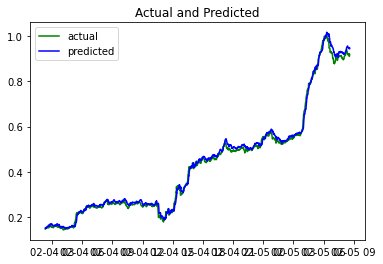

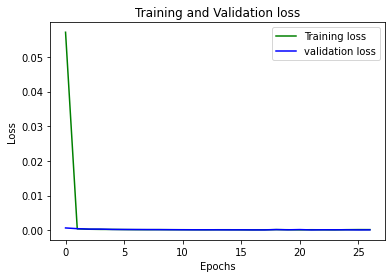

In [ ]:
result=resultados(
            model = "narx",
            ts=('BNB-USD'), 
            period = "7d",
            interval = "1m",
            epochs=500, 
            patience = 10,
            delay=0,
            )

[*********************100%***********************]  1 of 1 completed
Janela Temporal entre 894 e 1715


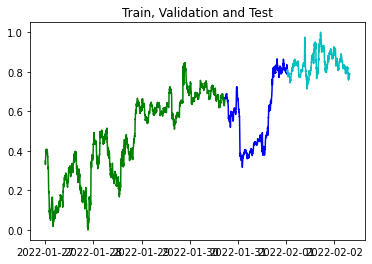

Epoch 1/1000
138/138 [==============================] - 0s 3ms/step - loss: 3.3594e-04 - val_loss: 8.0731e-05
Epoch 2/1000
138/138 [==============================] - 0s 3ms/step - loss: 6.0070e-05 - val_loss: 5.1216e-05
Epoch 3/1000
138/138 [==============================] - 0s 3ms/step - loss: 5.5782e-05 - val_loss: 5.3123e-05
Epoch 4/1000
138/138 [==============================] - 0s 3ms/step - loss: 5.7419e-05 - val_loss: 5.0975e-05
Epoch 5/1000
138/138 [==============================] - 0s 3ms/step - loss: 5.2584e-05 - val_loss: 4.8435e-05
Epoch 6/1000
138/138 [==============================] - 0s 3ms/step - loss: 5.2903e-05 - val_loss: 5.6276e-05
Epoch 7/1000
138/138 [==============================] - 0s 3ms/step - loss: 5.1004e-05 - val_loss: 4.7011e-05
Epoch 8/1000
138/138 [==============================] - 0s 3ms/step - loss: 5.4448e-05 - val_loss: 4.8900e-05
Epoch 9/1000
138/138 [==============================] - 0s 3ms/step - loss: 5.7472e-05 - val_loss: 4.6440e-05
Epoch 10/1

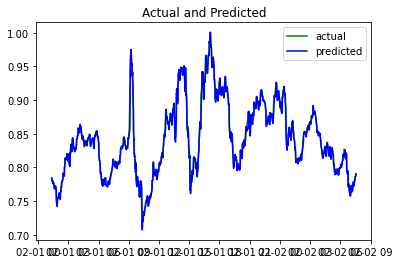

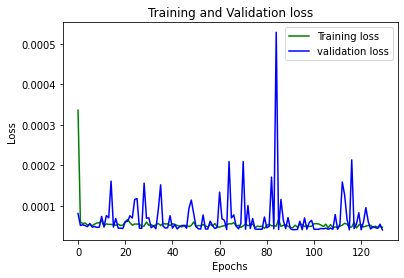

In [ ]:
resultados(
            model = "narx",
            ts=('BTC-USD'), 
            period = "7d",
            interval = "1m",
            epochs=1000, 
            patience = 50,
            delay=0,
            )

[*********************100%***********************]  1 of 1 completed
Janela Temporal 2 , 1135 e 2196


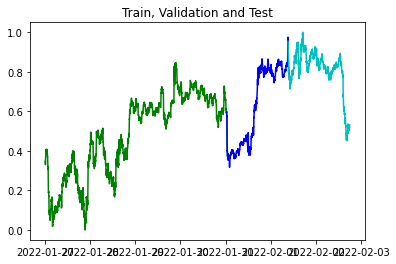

Epoch 1/1000
176/176 [==============================] - 1s 4ms/step - loss: 0.0804 - val_loss: 0.0011
Epoch 2/1000
176/176 [==============================] - 1s 3ms/step - loss: 9.1975e-04 - val_loss: 0.0012
Epoch 3/1000
176/176 [==============================] - 1s 4ms/step - loss: 6.2167e-04 - val_loss: 4.9245e-04
Epoch 4/1000
176/176 [==============================] - 1s 4ms/step - loss: 4.2880e-04 - val_loss: 2.7858e-04
Epoch 5/1000
176/176 [==============================] - 1s 4ms/step - loss: 3.2135e-04 - val_loss: 2.1724e-04
Epoch 6/1000
176/176 [==============================] - 1s 4ms/step - loss: 2.5651e-04 - val_loss: 1.5573e-04
Epoch 7/1000
176/176 [==============================] - 1s 4ms/step - loss: 1.7238e-04 - val_loss: 1.2671e-04
Epoch 8/1000
176/176 [==============================] - 1s 7ms/step - loss: 1.3783e-04 - val_loss: 1.3210e-04
Epoch 9/1000
176/176 [==============================] - 1s 4ms/step - loss: 1.9632e-04 - val_loss: 1.2823e-04
Epoch 10/1000
176/176 

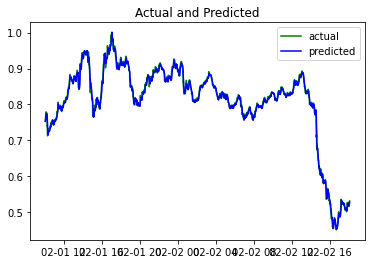

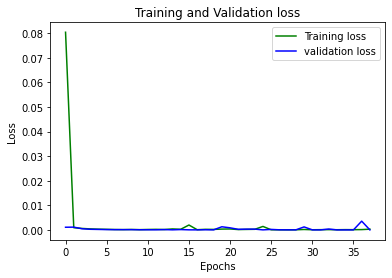

In [ ]:
result=resultados(
            model = "narx",
            ts=('BTC-USD'), 
            period = "7d",
            interval = "1m",
            epochs=1000, 
            patience = 10,
            delay=1,
            )

[*********************100%***********************]  1 of 1 completed
Janela Temporal entre 894 e 1715


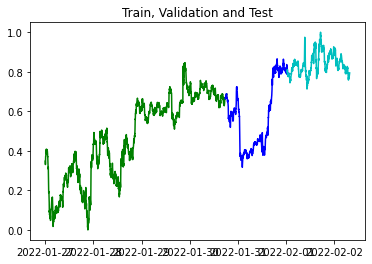

Epoch 1/10000
138/138 [==============================] - 0s 3ms/step - loss: 4.9824e-05 - val_loss: 5.0918e-05
Epoch 2/10000
138/138 [==============================] - 0s 3ms/step - loss: 4.4327e-05 - val_loss: 4.6804e-05
Epoch 3/10000
138/138 [==============================] - 0s 3ms/step - loss: 5.6710e-05 - val_loss: 4.1215e-05
Epoch 4/10000
138/138 [==============================] - 0s 3ms/step - loss: 4.8183e-05 - val_loss: 5.1900e-05
Epoch 5/10000
138/138 [==============================] - 1s 4ms/step - loss: 4.8317e-05 - val_loss: 4.0725e-05
Epoch 6/10000
138/138 [==============================] - 0s 3ms/step - loss: 5.4467e-05 - val_loss: 5.3137e-05
Epoch 7/10000
138/138 [==============================] - 0s 3ms/step - loss: 4.9261e-05 - val_loss: 4.4965e-05
Epoch 8/10000
138/138 [==============================] - 0s 3ms/step - loss: 4.9760e-05 - val_loss: 4.2812e-05
Epoch 9/10000
138/138 [==============================] - 0s 3ms/step - loss: 4.9269e-05 - val_loss: 4.0629e-05
E

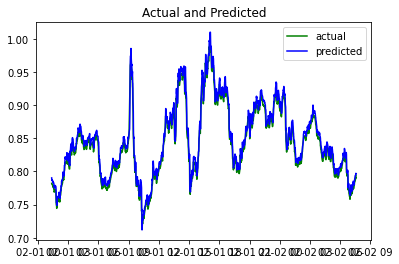

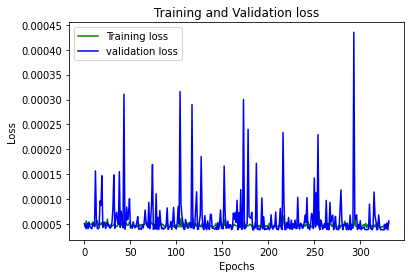

In [ ]:
resultados(
            model = "narx",
            ts=('BTC-USD'), 
            period = "7d",
            interval = "1m",
            epochs=1000, 
            patience = 100,
            delay=0,
            )

[*********************100%***********************]  1 of 1 completed
Janela Temporal entre 627 e 1153


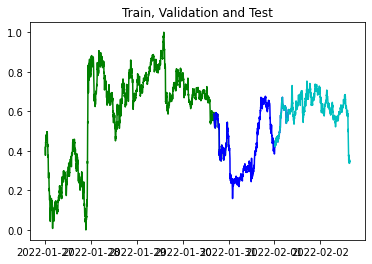

Epoch 1/1000
165/165 [==============================] - 1s 4ms/step - loss: 0.0900 - val_loss: 0.0050
Epoch 2/1000
165/165 [==============================] - 1s 4ms/step - loss: 0.0030 - val_loss: 0.0021
Epoch 3/1000
165/165 [==============================] - 0s 3ms/step - loss: 0.0021 - val_loss: 0.0056
Epoch 4/1000
165/165 [==============================] - 1s 4ms/step - loss: 0.0022 - val_loss: 0.0027
Epoch 5/1000
165/165 [==============================] - 0s 3ms/step - loss: 0.0019 - val_loss: 0.0049
Epoch 6/1000
165/165 [==============================] - 1s 4ms/step - loss: 0.0035 - val_loss: 0.0139
Epoch 7/1000
165/165 [==============================] - 1s 4ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 8/1000
165/165 [==============================] - 1s 4ms/step - loss: 0.0041 - val_loss: 0.0020
Epoch 9/1000
165/165 [==============================] - 1s 4ms/step - loss: 0.0063 - val_loss: 0.0013
Epoch 10/1000
165/165 [==============================] - 1s 4ms/step - loss: 0.002

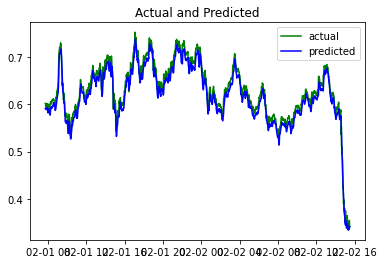

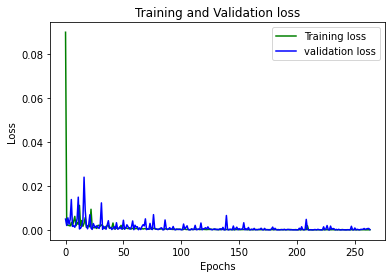

In [ ]:
resultados(
            model = "narx",
            ts=('BNB-USD'), 
            period = "7d",
            interval = "1m",
            epochs=1000, 
            patience = 100,
            delay=0,
            )

In [ ]:
resultados(ts=('TSLA'), 
               period = "7d",
               interval = "1m",
               epochs=5000,       
               patience = 50,
               delay=0,
               )

In [ ]:
result= resultados(ts=('XRP-USD'), 
               period = "7d",
               interval = "1m",
               epochs=5000, 
               patience = 50,
               delay=0,
               )

##MLP

In [ ]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense

def mlp(Time_Lag):
  # define model
  mlp = Sequential()
  mlp.add(Dense(Time_Lag, activation='sigmoid', input_dim=Time_Lag))
  mlp.add(Dense(round(2*np.sqrt(3*Time_Lag))))
  mlp.add(Dense(1))
  mlp.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.01, decay=1e-6),
              loss = "mse")
  return mlp

In [ ]:
result= resultados(
               model = "mlp",
               ts=('^BVSP'), 
               period = "max",
               interval = "1d",
               epochs=1000, 
               patience = 30,
               delay=1,
               )

[*********************100%***********************]  1 of 1 completed
Importação da série temporal concluida
Tau = 1
Dy = 39
Dy2 = 4
Data Train, Data Validation and Data Test
Normalização concluida
1
Divisão dos dados em Treino, validação e teste
Load Model
Rolling Window
Epoch 1/1000
133/133 [==============================] - 1s 6ms/step - loss: 0.0127 - val_loss: 0.0013
Epoch 2/1000
133/133 [==============================] - 1s 4ms/step - loss: 6.0405e-04 - val_loss: 8.5510e-04
Epoch 3/1000
133/133 [==============================] - 1s 5ms/step - loss: 3.9486e-04 - val_loss: 0.0011
Epoch 4/1000
133/133 [==============================] - 1s 5ms/step - loss: 3.5267e-04 - val_loss: 4.3384e-04
Epoch 5/1000
133/133 [==============================] - 1s 5ms/step - loss: 2.1992e-04 - val_loss: 3.6007e-04
Epoch 6/1000
133/133 [==============================] - 1s 5ms/step - loss: 2.4358e-04 - val_loss: 3.8086e-04
Epoch 7/1000
133/133 [==============================] - 1s 5ms/step - loss: 1.92

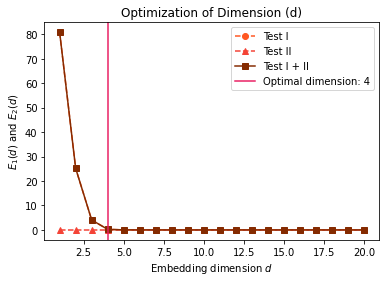

In [ ]:
result= resultados(
               model = "mlp",
               ts=('^BVSP'), 
               period = "max",
               interval = "1d",
               epochs=1000, 
               patience = 30,
               delay=1,
               )

In [ ]:
train, valid, test, index , pacf, fac_min, fac_max , tau , dy = Train_Validation_Test(df)
train , min, max = MinMax(train)
valid = MinMax_valid_test(valid,min,max)
test = MinMax_valid_test(test,min,max)
X, y = split_sequence_takens(train,tau, dy, delay=1)   
X_val, y_val = split_sequence_takens(valid,tau, dy, delay=0) 
X_test, y_test = split_sequence_takens(test,tau, dy, delay=0) 

In [ ]:
#Test Model
pred_array=result[3].predict(X_test, verbose=1)

predicted , actual = pd.DataFrame((pred_array), index=index), pd.DataFrame(np.array(y_test), index=index)
predicted , actual = predicted.rename(columns={0: "close"}), actual.rename(columns={0: "close"})  
evaluate_all(actual,predicted) 

pred_array=result[3].predict(X, verbose=1)
index_train= train[dy:].index
train_predict , train_real = pd.DataFrame((pred_array), index=index_train) , pd.DataFrame(np.array(y), index=index_train)
train_predict , train_real = train_predict.rename(columns={0: "close"}) , train_real.rename(columns={0: "close"})
 
evaluate_all(train_real,train_predict) 

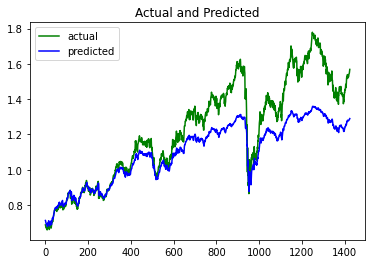

In [ ]:
+plt.plot(np.array(result[0]), 'g', label='actual')
plt.plot(np.array(result[1]), 'b', label='predicted')
plt.title('Actual and Predicted')
plt.legend()
plt.show()

##DELP

In [ ]:
def resultados(ts=('^BVSP'), 
               epochs=1000, 
               delay=1,
               ):
  
  #Importação da Serie Temporal
  TS = Ticker(ts)
  start='2000-12-01'
  end='2021-12-20'
  df=TS.history(start=start, end=end)
  df=df.reset_index(level=[0])
  df.index = pd.to_datetime(df.index)
  del df['symbol']
  df = df['close'] 

  #Normalização MinMax
  df= MinMax(df)

  #Função de AutoCorrelação
  acf_values=sm.tsa.stattools.acf(MinMax(df), nlags=(len(MinMax(df))-1),fft=True)
  fac_min, fac_max = np.where(acf_values<=1/np.e)[0][0],np.where(acf_values<=0)[0][0]
  print("Janela Temporal entre "+str(fac_min)+" e " +str(fac_max))

  #TimeLags
  Time_Lag = 44

  #Model
  model=narx

  #Teste de Estacionariedade(ADF)  
  #adf((df - df.shift()))

  train, valid, test,index = Train_Validation_Test(df,Time_lag = Time_Lag)

  #Index Data
  index = index.index  
  #Split Train Data
  X, y = split_sequence(train, Time_Lag)[0][:] , split_sequence(train, Time_Lag)[1][:]   
  X_val, y_val = split_sequence(train, Time_Lag)[0][:] , split_sequence(train, Time_Lag)[1][:]   
  X_test, y_test = split_sequence(test, Time_Lag)[0][:] , split_sequence(train, Time_Lag)[1][:] 

  es = tf.keras.callbacks.EarlyStopping(monitor='loss', verbose=1, patience=10)
  mc = tf.keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

  #Train Model With (Error stabilization stop criterion)
  X = X.reshape((X.shape[0], X.shape[1]))
  history=model.fit(X, y, 
                    epochs=epochs, 
                    validation_data=(X_val, y_val),
                    callbacks=[tensorboard_callback,es]
                    )
  #Test Model
  pred_array=[]
  for e in range(len(X_test)):
      pred_array.append(model.predict(np.array([X_test[e],]), verbose=0)[0])
  
  predicted = pd.DataFrame((pred_array), index=index)
  predicted = predicted.rename(columns={0: "close"})

  actual = pd.DataFrame(test, index=index)
  actual = actual.rename(columns={0: "close"})  

  #Results
  evaluate_all(actual,predicted)

  plt.plot(actual, 'g', label='actual')
  plt.plot(predicted, 'b', label='predicted')
  plt.title('Actual and Predicted')
  plt.legend()
  plt.show()

  visualize_loss(history, "Training and Validation Loss")

  return actual,predicted,history
result = resultados()

###Working

In [ ]:
def resultados(ts=('^BVSP'), 
               model = "narx",
               period = "7d",
               interval = "1m",
               epochs=10000, 
               patience = 10,
               delay=1,
               ):
  
  #Importação da Serie Temporal
  df = importdata(ts,period,interval)
  print("Importação da série temporal concluida")
  
  #Data Train, Data Validation and Data Test
  train, valid, test, index , pacf, fac_min, fac_max , tau , dy = Train_Validation_Test(df)
  print("Data Train, Data Validation and Data Test")

  #Normalização MinMax
  train , min, max = MinMax(train)
  valid = MinMax_valid_test(valid,min,max)
  test = MinMax_valid_test(test,min,max)

  #Diferenciação
  #train = diff(train_)
  #valid = diff(valid_)
  #test = diff(test_)

  print("Normalização concluida")
  if False: 
    plt.plot(train, 'g', label='Train')
    plt.plot(valid, 'b', label='Validação')
    plt.plot(test, 'c', label='Test')
    plt.title('Train, Validation and Test')
    plt.show()

  #Index Data
  index = test[dy:].index
  print("1")
  print("Divisão dos dados em Treino, validação e teste")

  #Teste de Estacionariedade(ADF)  
  #adf((df - df.shift()))

  #Model
  if model == "narx":
     model=narx(round(dy))
  elif model == 'mlp':
     model= mlp(round(dy))  
  elif model == 'lstm':
     model= lstm(round(dy))
  
  print("Load Model")
  
  #Time Series Split Rolling Window
  X, y = split_sequence_takens(train,tau, dy, delay)   
  X_val, y_val = split_sequence_takens(valid,tau, dy, delay) 
  X_test, y_test = split_sequence_takens(test,tau, dy, delay=0) 
  print("Rolling Window")

  es = tf.keras.callbacks.EarlyStopping(monitor='loss', verbose=1, patience=patience)
  mc = tf.keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

  #Train Model With (Error stabilization stop criterion)
  X = X.reshape((X.shape[0], X.shape[1]))  
  history=model.fit(X, y, 
                    verbose=1,
                    epochs=epochs, 
                    validation_data=(X_val, y_val),
                    callbacks=[tensorboard_callback,es]
                    )
  print("Train Model")

  #Test Model
  pred_array=model.predict(X_test, verbose=1)
  print("Predict Model")
  print(len(pred_array),len(y_test), len(index))
 
  predicted , actual = pd.DataFrame((pred_array), index=index), pd.DataFrame(np.array(y_test), index=index)
  predicted , actual = predicted.rename(columns={0: "close"}), actual.rename(columns={0: "close"})  

  #Results
  evaluate_all(actual,predicted)  
  print("Resultados")

  return actual,predicted,history,model

In [ ]:
def resultados(ts=('^BVSP'), 
               model = "narx",
               period = "7d",
               interval = "1m",
               epochs=10000, 
               patience = 10,
               delay=1,
               ):
  
  #Importação da Serie Temporal
  df = importdata(ts,period,interval)

  #Normalização MinMax
  df= MinMax(df)

  #Função de AutoCorrelação
  pacf, fac_min, fac_max  = acf_pacf(MinMax(df))

  #TimeLags
  Time_Lag = round(np.sqrt(fac_max))

  #Model
  if model == "narx":
     model=narx(Time_Lag)
  elif model == 'mlp':
     model= mlp(Time_Lag)

  #Teste de Estacionariedade(ADF)  
  #adf((df - df.shift()))

  #Data Train, DataValidation and Data Test
  train, valid, test, index = Train_Validation_Test(df, Time_Lag)

  #Index Data
  index = index.index  
  
  #Time Series Split Rolling Window
  X, y = split_sequence(train, Time_Lag, delay)   
  X_val, y_val = split_sequence(train, Time_Lag, delay=0) 
  X_test, y_test = split_sequence(test, Time_Lag, delay=0) 

  es = tf.keras.callbacks.EarlyStopping(monitor='loss', verbose=1, patience=patience)
  mc = tf.keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

  #Train Model With (Error stabilization stop criterion)
  X = X.reshape((X.shape[0], X.shape[1]))
  history=model.fit(X, y, 
                    verbose=1,
                    epochs=epochs, 
                    validation_data=(X_val, y_val),
                    callbacks=[tensorboard_callback,es]
                    )
  #Test Model
  pred_array=model.predict(X_test, verbose=1)
  
  predicted , actual = pd.DataFrame((pred_array), index=index), pd.DataFrame(test, index=index)
  predicted , actual = predicted.rename(columns={0: "close"}), actual.rename(columns={0: "close"})  

  #Results
  evaluate_all(actual,predicted)

  plt.plot(actual, 'g', label='actual')
  plt.plot(predicted, 'b', label='predicted')
  plt.title('Actual and Predicted')
  plt.legend()
  plt.show()

  visualize_loss(history, "Training and Validation Loss")

  return actual,predicted,history

In [ ]:
import numpy as np
from scipy.stats import entropy
from math import log, e
import pandas as pd

import timeit

def entropy1(labels, base=None):
  value,counts = np.unique(labels, return_counts=True)
  return entropy(counts, base=base)

def entropy2(labels, base=None):
  """ Computes entropy of label distribution. """

  n_labels = len(labels)

  if n_labels <= 1:
    return 0

  value,counts = np.unique(labels, return_counts=True)
  probs = counts / n_labels
  n_classes = np.count_nonzero(probs)

  if n_classes <= 1:
    return 0

  ent = 0.

  # Compute entropy
  base = e if base is None else base
  for i in probs:
    ent -= i * log(i, base)

  return ent

def entropy3(labels, base=None):
  vc = pd.Series(labels).value_counts(normalize=True, sort=False)
  base = e if base is None else base
  return -(vc * np.log(vc)/np.log(base)).sum()

def entropy4(labels, base=None):
  value,counts = np.unique(labels, return_counts=True)
  norm_counts = counts / counts.sum()
  base = e if base is None else base
  return -(norm_counts * np.log(norm_counts)/np.log(base)).sum()